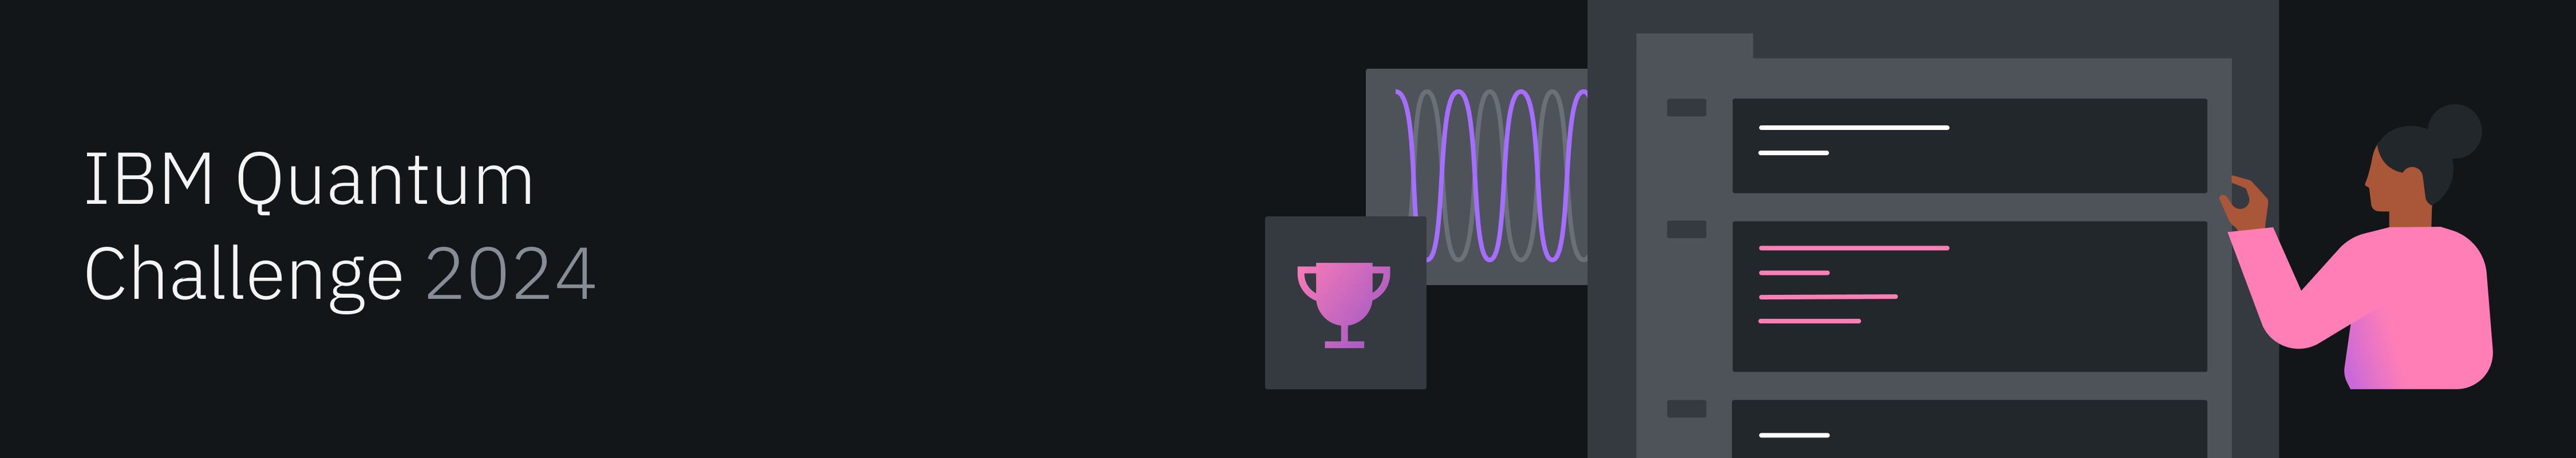

# 実際のバックエンドでVQCをテストする(2024年 Lab4)

この Lab では、Qiskit Patterns のワークフローを使用して、理想的なバックエンド上でシンプルな変分量子分類器 (Variational Quantum Classifier, VQC) を構築し、学習させる方法を学びます。学習された VQC の性能が、ノイズに対してどのように影響を受けるかを体験します。最後に、VQC の深さを浅くする方法を学び、得られた回路を量子ハードウェア上で実行し、エラー抑制やエラー緩和の技術が結果にどのような影響を与えるかを確認します。

まず、この Lab で必要となるすべてのライブラリーをインポートすることから始めましょう：

## Setup

In [1]:
# ### Install Qiskit and relevant packages, if needed
# ### IMPORTANT: Make sure you are on 3.10 > python < 3.12
# %pip install qiskit[visualization]==1.0.2
# %pip install qiskit-ibm-runtime
# %pip install qiskit-aer
# %pip install graphviz
# %pip install qiskit-serverless -U
# %pip install qiskit-transpiler-service -U

In [2]:
# Import all in one cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

In [3]:
# Load your API token in .env
import os
from dotenv import load_dotenv

os.environ.pop('QXInstance', None)
os.environ.pop('QXToken', None)

load_dotenv()

instance = os.environ['QXInstance']
token = os.environ['QXToken']

## Part 1: 理想的なバックエンドで VQC を設計する

変分量子分類器 (VQC) は変分量子アルゴリズムの一種で、ある種の分類問題を解くことができるます。特に、VQC はハイブリッドアーキテクチャーを特徴としています。このアーキテクチャーは、パラメーター化された量子回路を初期状態に適用した形の ansatz に基づいています。出力はコスト関数の形で測定され、このコスト関数は回路のパラメーターに対して古典的に最適化され、最小値に収束します。

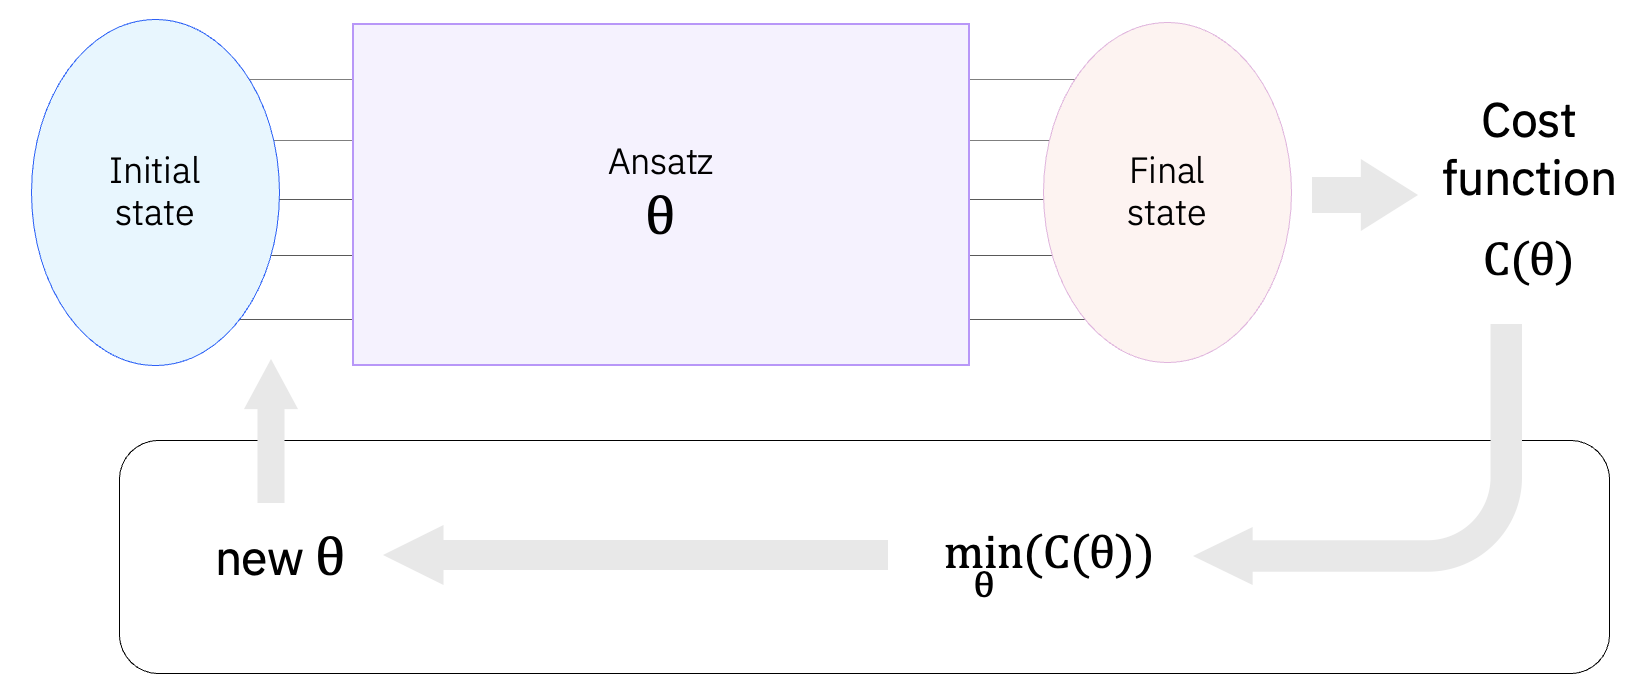


この Lab では、10羽の鳥のリストが与えられます：

 > Falcon, Hummingbird, Eagle, Osprey, Heron, Peacock, Parrot, Swan, Toucan, Cardinal.
 > 
 > (ハヤブサ、ハチドリ、ワシ、ミサゴ、サギ、クジャク、オウム、白鳥、オオハシ、ショウジョウコウカンチョウ)

リストの最初の5羽は IBM Quantum の鳥です。プロセッサー・タイプの名前がこれらの鳥にちなんで付けられているためです - [こちら](https://docs.quantum.ibm.com/run/processor-types) をご確認ください。残りの鳥は IBM Quantum 以外の鳥です。

データセットは *bird_dataset.csv* という辞書型で与えられます。それぞれの鳥は各行に対応し、状態ベクトル形式で与えられた5量子ビットの量子状態と関連付けられています。したがって、各鳥に対して $2^5 = 32$ 個の係数が見つかります。

この問題では、IBM Quantum の鳥はエンタングルされた量子状態に関連付けられ、IBM Quantum ではない鳥はエンタングルされていない(積の)量子状態に関連付けられます。エンタングルされた量子状態とそうでない量子状態を区別することは、一般に簡単な問題ではないことがわかります。この Lab の目標は、この2つの鳥を区別できる VQC を作ることです。

でも心配しないでください！ [Qiskit Patterns](https://www.ibm.com/quantum/blog/qiskit-patterns)** に基づいたワークフローを使って、アルゴリズムの全ステップをガイドします。

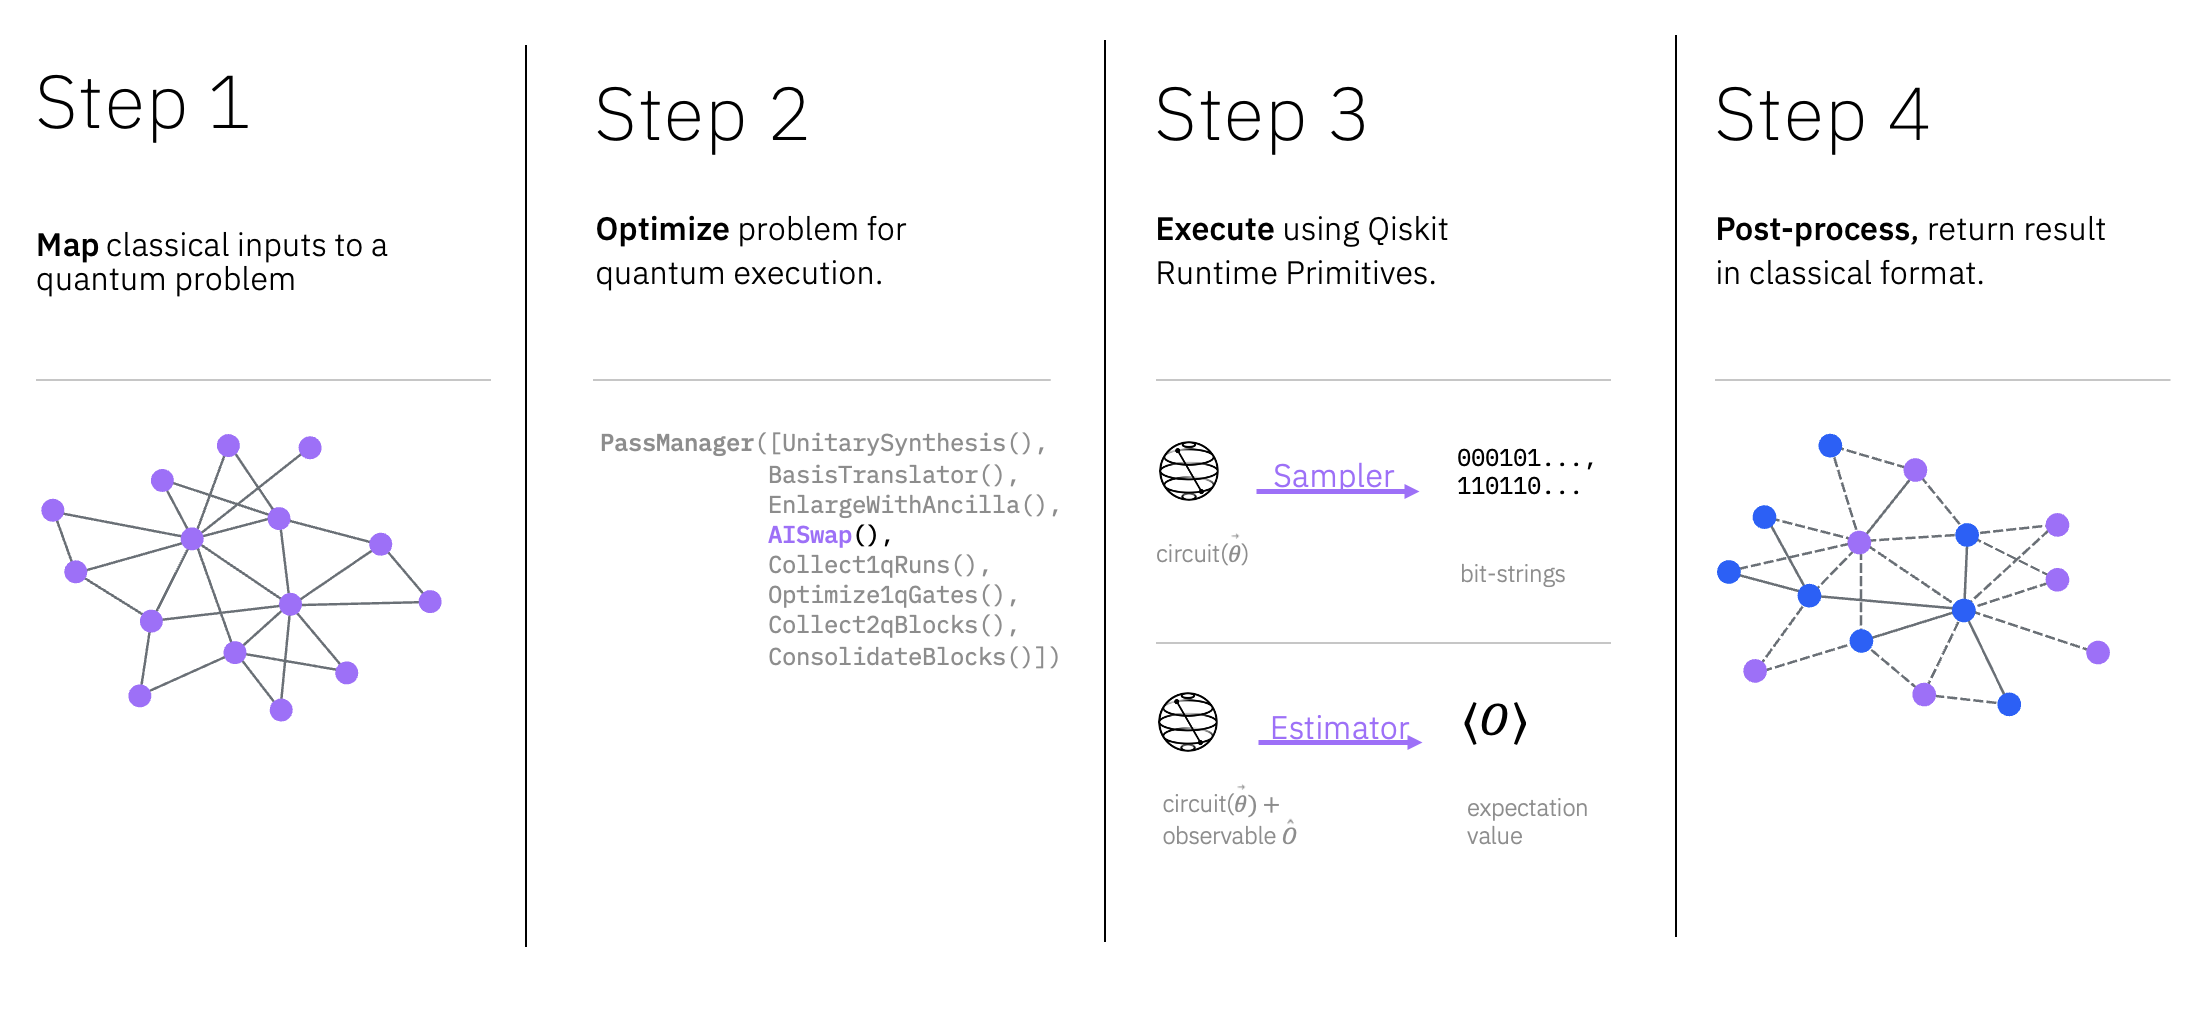


** Qiskit Patternsは、変分量子アルゴリズムだけでなく、どのようなタイプの問題にも適用できる一般的なワークフローであることに注意してください！

### Step 1: 古典的な入力を量子問題にマップする

Qiskit Patterns のこのステップでは、量子ハードウェア上で実行可能な量子回路と測定セットに問題を変換します。これは一般的に難しい問いであることに注意してください。

そのため、考慮すべき項目リストを以下に示します。

- 古典的に難しい問題を選びます。エンタングル状態と非エンタングル状態の識別は、学習目的のために小規模な問題を選んでいるとはいえ、古典的に難しい問題です。
- 結果を期待値やコスト関数に変換する必要があります。コスト関数は、問題の結果を最小化または最大化すべきものとして定義する問題固有の関数であり、化学、機械学習、金融、最適化など様々な用途の変分量子アルゴリズムに一般的に使用されます。
- 可能な限り、使用するハードウェアの制限と利点を念頭に置くべきです。特に、バックエンドの接続性は重要です。多くのSWAPゲートを実装する必要がないように、IBM Quantum プロセッサーの heavy-hex トポロジーにできるだけ近い回路に問題をマッピングします。

とりあえず、まず古典的なデータを取得しましょう。この場合、それぞれの鳥の状態ベクトル係数です。

```{caution}
このノートブックには同じ階層の`data`フォルダ配下に追加のスクリプトが必要です。  
`birds_dataset_2024.csv`, `params_0_list_2024.npy`, `opt_params_shallow_VQC_2024.npy`
```

In [4]:
# Define num_qubits, the number of qubits, for the rest of the Lab
num_qubits = 5

# Load the dictionary 
birds_dataset = pd.read_csv('./data/birds_dataset_2024.csv') 

# Check if the dataset is loaded correctly - coefficients should be complex numbers
for i in range(2**num_qubits):
    key = 'c%.0f' %i
    birds_dataset[key] = birds_dataset[key].astype(np.complex128)

# Print the dataset
birds_dataset

names                  c0                  c1                  c2  \
0       Falcon  0.707107+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
1  Hummingbird  0.000000+0.000000j  0.707107+0.000000j  0.000000+0.000000j   
2        Eagle  0.000000+0.000000j  0.000000+0.000000j  0.707107+0.000000j   
3       Osprey  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
4        Heron  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
5      Peacock  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
6       Parrot  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
7         Swan  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
8       Toucan  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
9     Cardinal  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   

                   c3                  c4        c5        c6        c7  \
0  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
1  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
2  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
3  0.707107+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
4  0.000000+0.000000j  0.707107+0.000000j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
5  0.000000+0.000000j  0.000000+0.000000j  1.0+0.0j  0.0+0.0j  0.0+0.0j   
6  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  1.0+0.0j  0.0+0.0j   
7  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j  1.0+0.0j   
8  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
9  0.000000+0.000000j  0.000000+0.000000j  0.0+0.0j  0.0+0.0j  0.0+0.0j   

         c8  ...       c22       c23       c24       c25       c26  \
0  0.0+0.0j  ...  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
1  0.0+0.0j  ...  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
2  0.0+0.0j  ...  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
3  0.0+0.0j  ...  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
4  0.0+0.0j  ...  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
5  0.0+0.0j  ...  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
6  0.0+0.0j  ...  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
7  0.0+0.0j  ...  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
8  1.0+0.0j  ...  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   
9  0.0+0.0j  ...  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0+0.0j   

                  c27                 c28                 c29  \
0  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.707107+0.000000j   
3  0.000000+0.000000j  0.707107+0.000000j  0.000000+0.000000j   
4  0.707107+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
5  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
6  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
7  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
8  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
9  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   

                  c30                 c31  
0  0.000000+0.000000j  0.707107+0.000000j  
1  0.707107+0.000000j  0.000000+0.000000j  
2  0.000000+0.000000j  0.000000+0.000000j  
3  0.000000+0.000000j  0.000000+0.000000j  
4  0.000000+0.000000j  0.000000+0.000000j  
5  0.000000+0.000000j  0.000000+0.000000j  
6  0.000000+0.000000j  0.000000+0.000000j  
7  0.000000+0.000000j  0.000000+0.000000j  
8  0.000000+0.000000j  0.000000+0.000000j  
9  0.000000+0.000000j  0.000000+0.000000j  

[10 rows x 33 columns]

#### Exercise 1: データセットの探索
    
```{admonition} Exercise

各量子状態の係数を取得し、それらを複素数を含むリストのリスト`[[], [], [], ...]` に保存してください。

IBM Quantum の鳥の場合は1のラベルを、そうでない鳥の場合は0のラベルを付与したリスト`[int, int, ...]`を作成してください。

````

In [5]:
list_coefficients = birds_dataset.filter(like='c', axis=1).values.tolist() # Add your code here
list_labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0] # Add your code here

```{admonition} 解説
:class: tip, dropdown
データセットから　　
- IBM Quantum の鳥は、例えば Falcon だと $1/\sqrt{2} (|00000\rangle + |11111\rangle)$ のエンタングル状態  
- IBM Quantum でない鳥は、例えば Peacok だと $|00101\rangle$ の非エンタングル状態  
をとっていることがわかります。
```

データの準備ができたので、それを量子回路にマッピングします。この場合、Qiskit では [initialization](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.Initialize) によって簡単に実装できる **振幅埋め込み(amplitude embedding)** 技術を使います。$32$ 個の係数のそれぞれが、5量子ビットのヒルベルト空間の基底状態の 1 つの振幅に対応するため、振幅埋め込みはこの種のデータセットに対して簡単なマッピングです。後述するように、 `qc.initialize` はあらゆる量子状態をマッピングできる一般的な関数です。しかし、この関数は非常に深い回路につながる可能性があります。まだデータセットに関する完全な情報がないため、今のところはこのマッピング手法を使うことにします。

より一般的な分類問題に対しては、他のマッピングを考えることができます。マッピングの選択は、与えられたデータセットの構造に依存します。一般的には、データはパラメータ化された量子ゲートの集合のパラメーターにマッピングされます。典型的な例は、[ZZ Feature Map](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap) です。

振幅埋め込み回路を構築して、確認してみましょう：

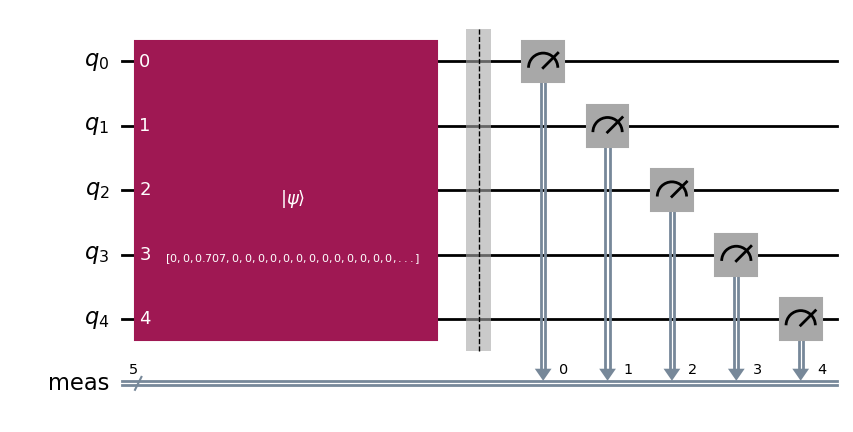

In [6]:
index_bird = 2 # You can check different birds by changing the index
amplitudes = list_coefficients[index_bird]

# Build the amplitude embedding 
qc = QuantumCircuit(5)
qc.initialize(amplitudes, range(num_qubits))
qc.measure_all()

# Draw the amplitude embedding circuit
qc.draw(output="mpl")

回路を描画する前に回路を分解(decompose)すると、その構造がよくわかります。上述したように、 ```qc.initialize()``` 関数は非常に深い回路になります。実は、任意の量子状態を効率的に量子回路にマッピングすることを目的とした状態準備の問題は、まだ未解決の研究課題です。

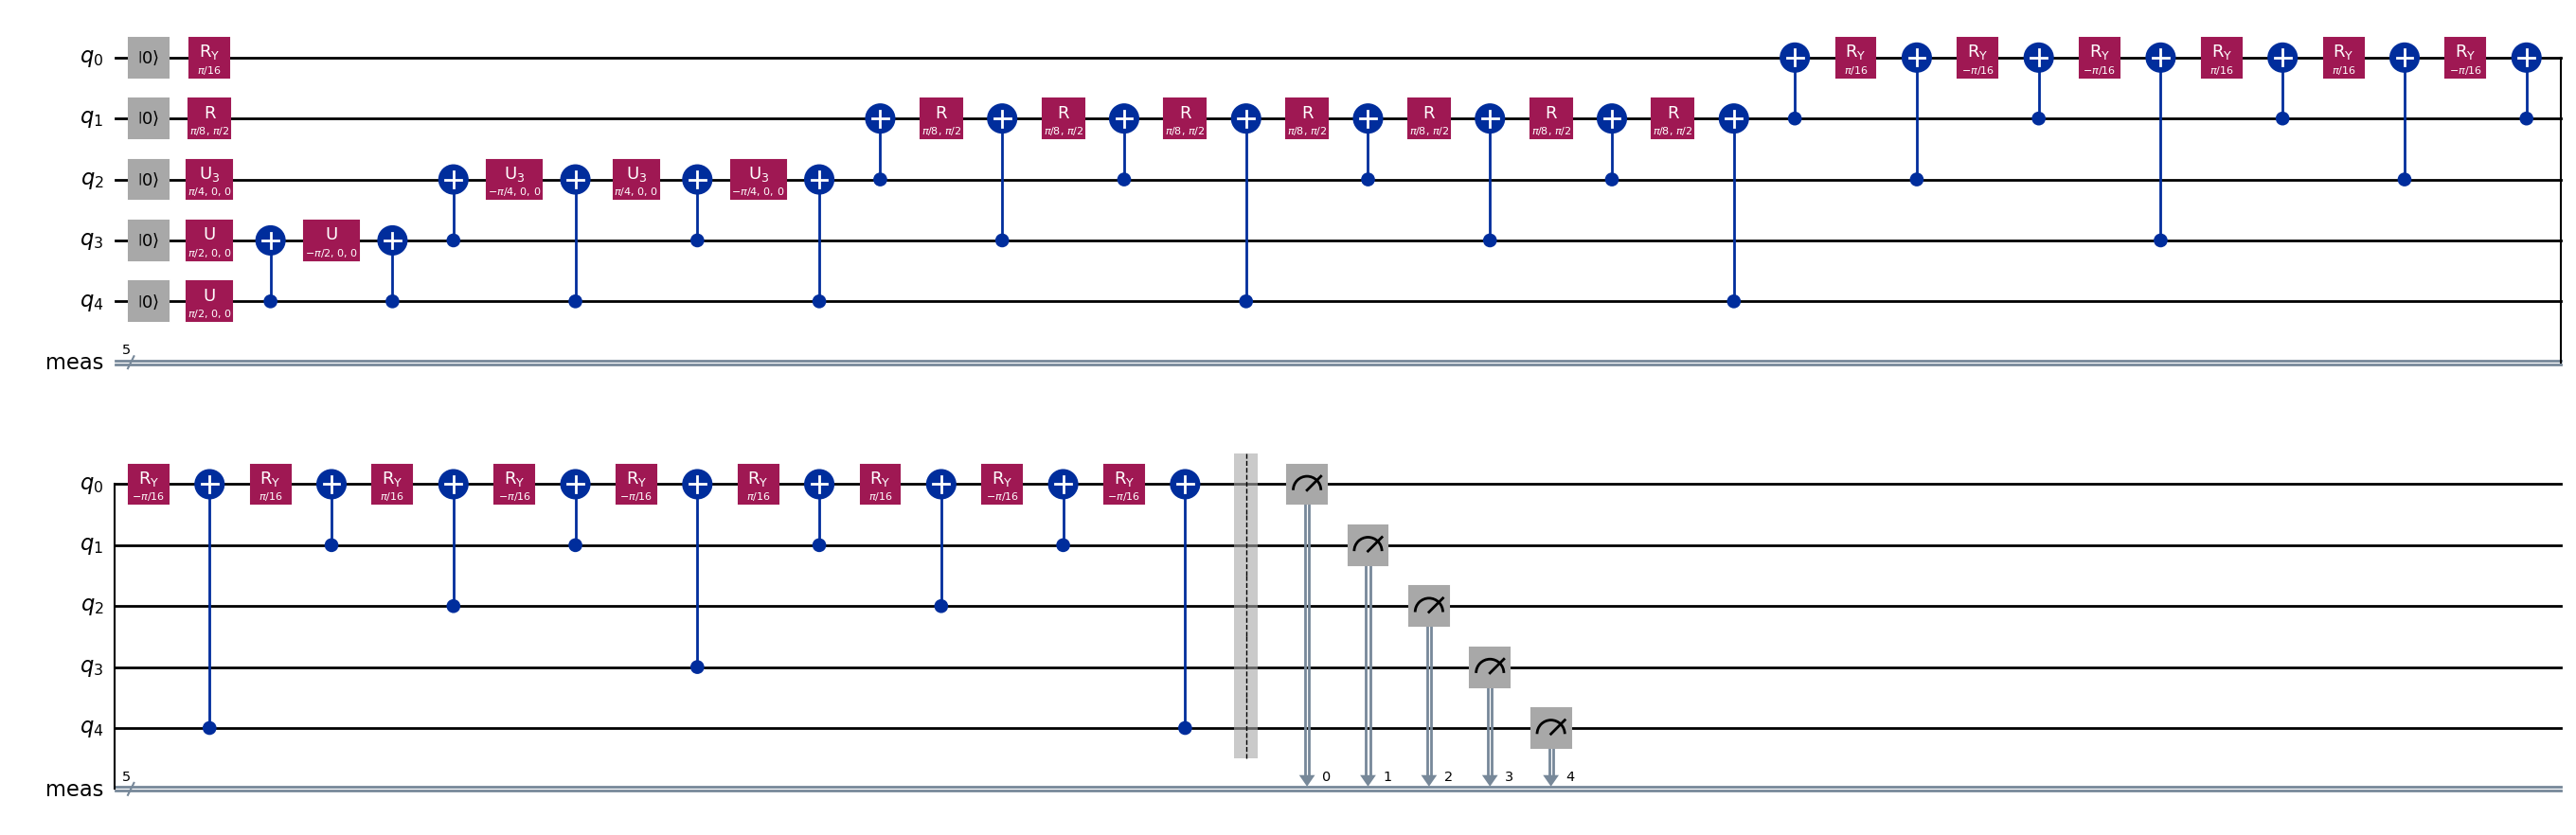

In [7]:
# Draw the decomposition of the amplitude embedding circuit
qc.decompose(reps=8).draw(output="mpl", fold=40)

初期状態が準備できたら、VQCの変分ansatzを構築する必要があります。このansatzは通常、パラメーター化された回転ゲートとエンタングルレイヤーの集合からなり、所定の回数繰り返されます。回転のパラメーターを調整することで、ヒルベルト空間の特定の領域を探索することができます。

目的の解に収束する適切なansatzを選択することは簡単な問題ではありません。一般に、考慮すべきトレードオフがいくつかあります：

- **スピード**： 探索空間を減らすことで、ゲートの数とansatzの深さを減らし、アルゴリズムを高速に実行します。
- **精度**： 探索空間の縮小は、問題の実際の解を除外してしまう危険性があり、最適解を下回るリスクがあります。
- **ノイズ**： より深い回路はノイズの影響を受けるので、ansatzの接続性、ゲート、ゲートの fidelity を実験する必要があります。

> 変分量子回路のansatzの設計方法について詳しく知りたい場合は、IBM Learning Platform の [Variational algorithm design](https://learning.quantum.ibm.com/course/variational-algorithm-design) コースを受講することを強くお勧めします。

[Qiskit circuit library](https://docs.quantum.ibm.com/api/qiskit/circuit_library#n-local-circuits) を確認すると、[`TwoLocal`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal)、[`EfficientSU2`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2)、[`RealAmplitudes`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RealAmplitudes) など、ansatzes を構築するための多くのアーキテクチャがあることがわかります。この Exercise では、[`RealAmplitudes`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RealAmplitudes) ansatzを選択します。

#### Exercise 2: ansatzの構築
```{admonition}Exercise

Qiskit circuit library の ```RealAmplitudes``` 回路を使用して以下のansatzを構築してください。

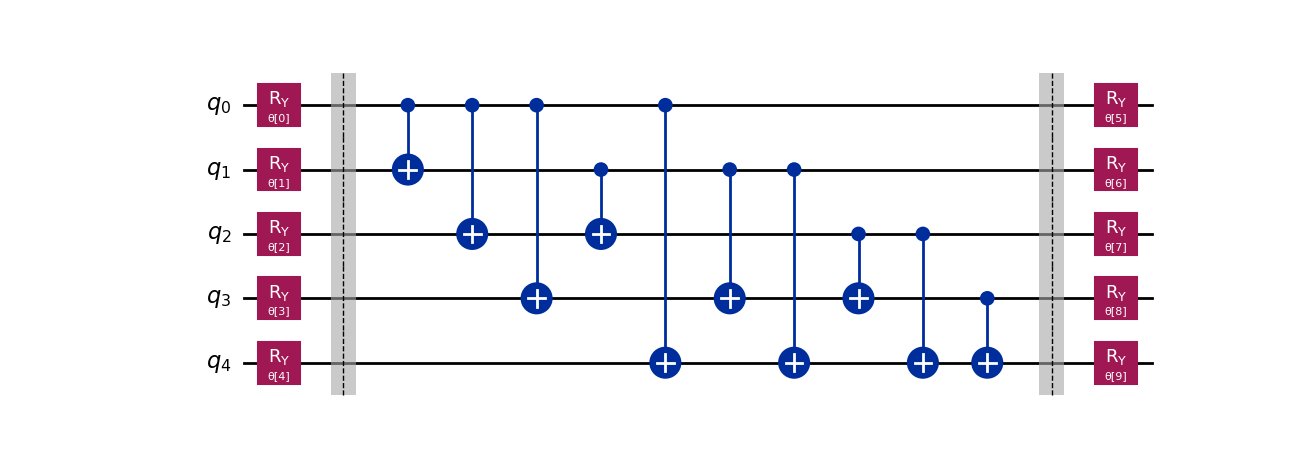

In [8]:
num_qubits = 5 # Add your code here
reps = 1 # Add your code here
entanglement = 'full' # Add your code here
ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement=entanglement, reps=reps) # Add your code here
# Add code here to draw the ansatz circuit

### Step 2: 問題の最適化
### Step 3: Qiskit primitivesを使って実行

Lab 2 で紹介した Qiskit Patterns の Step 2 では、量子ハードウェアに回路を効率的にマッピングするためのトランスパイル処理を扱います。  
[Transpilation](https://docs.quantum.ibm.com/transpile) には、回路の各論理量子ビットをデバイス内の実際の物理量子ビットにマッピングすることと、個々の量子ゲートを量子ハードウェア上で実行される演算シーケンスに変換することが含まれます。場合によっては、heavy-hex パターンに従うデバイスのトポロジーに適応させるために、SWAPゲートを追加する必要があります。

そして Step 3 では、Qiskit primitives を使って最終的な回路を実行します。今回は、VQC のコスト関数を構築するためにEstimator primitive を使用します。[Estimator primitive](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) は、複雑な代数プロセスを用いて、オブザーバブルを既知の固有基底を持つ他のオブザーバブルの組み合わせに分解することで、実際の量子デバイス上の期待値を推定します。

コスト関数は、データセットの各鳥の回路の出力に対するオブザーバブル $\hat{O}$ の期待値で定義されます：


$C(\theta) = \sum_{i\in \text{birds}} (\langle \psi_i(\theta) \vert \hat{O} \vert \psi_i(\theta) \rangle - L_i),$

ここで、 $\psi_i(\theta)$ は鳥 $i$ の回路の出力状態、$L_i$ は同じ鳥のラベルです。オブザーバブルは $\hat{O} = ZZZZZ$ であり、 $\theta$ は ansatz のパラメータベクトルです。

VQC の訓練に成功した場合、つまりコスト関数を最小化する最適なパラメーターセット $\theta^{opt}$ に到達した場合、VQC はIBM Quantumの鳥の場合は期待値$\langle ZZZZZ \rangle = 1$、非IBM Quantumの鳥の場合は期待値 $\langle ZZZZZ \rangle = 0$ を出力します。

In [9]:
# Define the observable 
obs = SparsePauliOp("ZZZZZ")

In [10]:
# Define the estimator and pass manager
estimator = StatevectorEstimator() #To train we use StatevectorEstimator to get the exact simulation
pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=3, seed_transpiler=0) 

In [11]:
# Define the cost function
def cost_func(params, list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    cost = 0
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.initialize(amplitudes)
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz) 
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        cost += np.abs(result - label)

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(cost)

    # Print the iterations to screen on a single line
    print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], cost),
        end="\r",
        flush=True,
    )
    
    return cost

### Step 4: 古典的な後処理

Qiskit Pattern の最後のステップでは、結果に対して古典的な後処理を行います。変分量子アルゴリズムの場合、このステージでは、定義したコスト関数を最小化するための ansatz パラメーターの古典最適化が含まれます。これはVQCを **訓練する** 部分です。

訓練を開始するには、パラメーターの初期セットを定義する必要があります。この初期点の選択は非常に重要なステップです！初期点を誤ると、トレーニングのプロセスが深刻な問題になる可能性があります。特に、オプティマイザが局所的最小値にはまり込んでしまうと、最適解に収束できなくなります。

ここでは、`params_0_list.npy` にある VQC の初期パラメーターの5つの設定を使用します。

In [12]:
# Intialize the lists to store the results from different runs
cost_history_list = []
res_list = []

# Retrieve the initial parameters
params_0_list = np.load("./data/params_0_list_2024.npy")

for it, params_0 in enumerate(params_0_list):

    print('Iteration number: ', it)
    
    # Initialize a callback dictionary
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    # Minimize the cost function using scipy
    res = minimize(
        cost_func, 
        params_0, 
        args=(list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict), 
        method="cobyla", # Classical optimizer
        options={'maxiter': 200}) # Maximum number of iterations
    
    # Print the results after convergence
    print(res)

    # Save the results from different runs
    res_list.append(res)
    cost_history_list.append(callback_dict["cost_history"])

Iteration number:  0
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 4.000011467451044
       x: [ 3.517e+00 -8.492e-04  5.588e-04  3.655e+00  4.717e+00
            1.571e+00  1.804e-03  6.281e+00  2.629e+00  3.145e+00]
    nfev: 200
   maxcv: 0.0
Iteration number:  1
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 2.9486038843201667e-08
       x: [-1.309e-07 -1.571e+00  1.571e+00 -1.104e+00  1.934e+00
            1.571e+00  1.571e+00 -2.869e-05  1.571e+00 -2.305e-05]
    nfev: 200
   maxcv: 0.0
Iteration number:  2
 message: Optimization terminated successfully.59]]
 success: True
  status: 1
     fun: 4.113279744917959
       x: [ 4.050e+00  3.146e+00  3.213e+00  3.439e+00  1.043e+00
            2.321e+00  3.105e+00  3.063e+00  3.192e+00  2.586e+00]
    nfev: 145
   maxcv: 0.0
Iteration number:  3
 message: Maximum number of function evaluations has been exceeded.
 succ

最適化されたパラメーターのリストを保存し、各初期点のコスト収束履歴をプロットします。

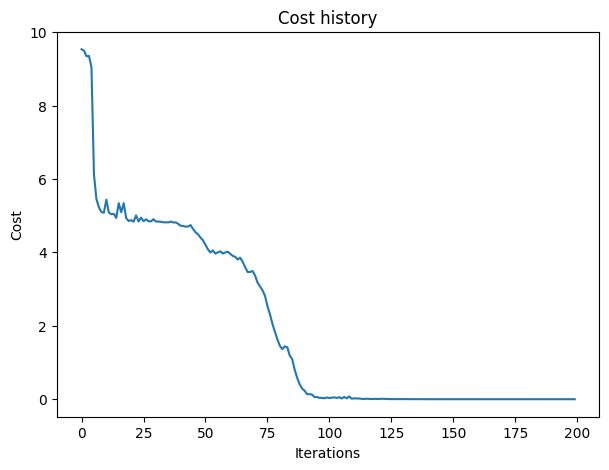

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost history')
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')

# Add your code here
y = cost_history_list[4]
x = range(len(y))
plt.plot(x, y)

#### Exercise 3: 最適なパラメータの検証
```{admonition}Exercise
どの初期パラメーターセットが最もよく収束するかをチェックする必要があります。そのために、Lab を通して使う2つの関数を定義してください。

1. 関数 `test_VQC` ：データセットの各鳥に最適なパラメーターを持つ回路を適用し、コスト関数の収束値を出力する
2. 関数 `compute performance`：各最適パラメーターセットに対するトータルパフォーマンス(P)を出力します。


$P = 100 - 100\cdot\sum_{i\in \text{birds}} \frac{\vert (\langle \psi_i(\theta_{opt}) \vert \hat{O} \vert \psi_i(\theta_{opt})\rangle - L_i\vert}{2^5}$.
```

In [14]:
def test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        list: List of test results
    """
    ### Write your code below here ###
    results_test = []
    for coefficients, labels in zip(list_coefficients, list_labels):
        num_qubits = 5
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.initialize(coefficients)
        # Initial state + ansats
        classifier = qc.compose(ansatz.decompose(reps=6)) 
        # Transpile classifier
        transpiled_classifier = pm.run(classifier) 
        # Run estimator
        pub = (transpiled_classifier, obs, opt_params)
        job = estimator.run([pub])
        # Get result
        result = np.abs(job.result()[0].data.evs)
        results_test.append(result)
        
    ### Don't change any code past this line ###                                 
    return results_test

In [15]:
def compute_performance(result_list, list_labels):
    
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels
        
    Returns:
        float: Performance of the classifier
    """
    ### Write your code below here ###
    performance = 100
    for result, label in zip(result_list, list_labels):
        performance -= 100 * np.abs(result - label) / 2**num_qubits
        
    ### Don't change any code past this line ###                                    
    return performance

Performance for trial 0: 93.97555178184847
Performance for trial 1: 99.99999990785612
Performance for trial 2: 90.85954362890645
Performance for trial 3: 86.57582851919992
Performance for trial 4: 99.99999469572624


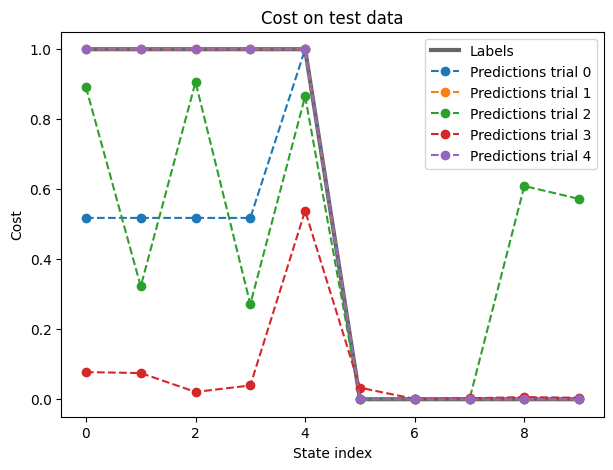

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

best_result_index = 0
best_performance = 0

for index in range(len(res_list)):
    opt_params = res_list[index].x
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)
    performance = compute_performance(results_test, list_labels)
    print(f"Performance for trial {index}: {performance}")
    ax.plot(results_test, 'o--', label='Predictions trial '+str(index))

    if performance > best_performance:
        best_result_index = index

ax.legend()

In [17]:
best_result_index

4

## Part 2: ノイズがVQCの性能に与える影響

VQCの訓練が完了したので、制御された方法でノイズを追加したときに、VQCが2つの鳥のセットを区別できるかどうかをテストしたいと思います。Lab のこのパートでは、ローカルテストに焦点を当てます。つまり、ローカルマシン上で量子ノイズをシミュレートします。このため、カスタムの fake backend を作成します。

その前に、量子ノイズの種類について少し説明しましょう：

1. **デコヒーレンス**： 量子ビットは初期化された後、特にアイドル状態が続くと、時間とともに量子状態の情報を失います。通常、デコヒーレンスにはエラー率を用いず、T1とT2の時間を用います。これは、量子ビットが情報を失うまでの時間です。
2. **測定エラー**： 量子ビットを測定するとエラーが発生する可能性があり、つまり、0の代わりに1が測定されたり、その逆が起こったりします。これは古典的なチャンネルと同様に機能します。
3. **ゲートエラー**： ゲートは完全ではないので、適用時にエラーを引き起こす可能性がわずかにあります。これは特にCX、CZ、ECRゲートのような2量子ビット・ゲートに当てはまり、通常1量子ビット・ゲートの約10倍のエラー率を持ちます。
4. **クロストーク・エラー**： ある量子ビットにゲートを適用すると、他の量子ビット、特に隣接する量子ビットも影響を受ける可能性があります。これは、これらの量子ビットがアイドル状態であっても同様です。幸いなことに、最新のHeronデバイスでは、この問題は少なくなっていますが、それでも注意すべきことです。

[IBM Quantum systems page](https://quantum.ibm.com/services/resources) では、量子デバイスのコヒーレンス時間やエラー率を直接見ることができます。以下はその概要です：

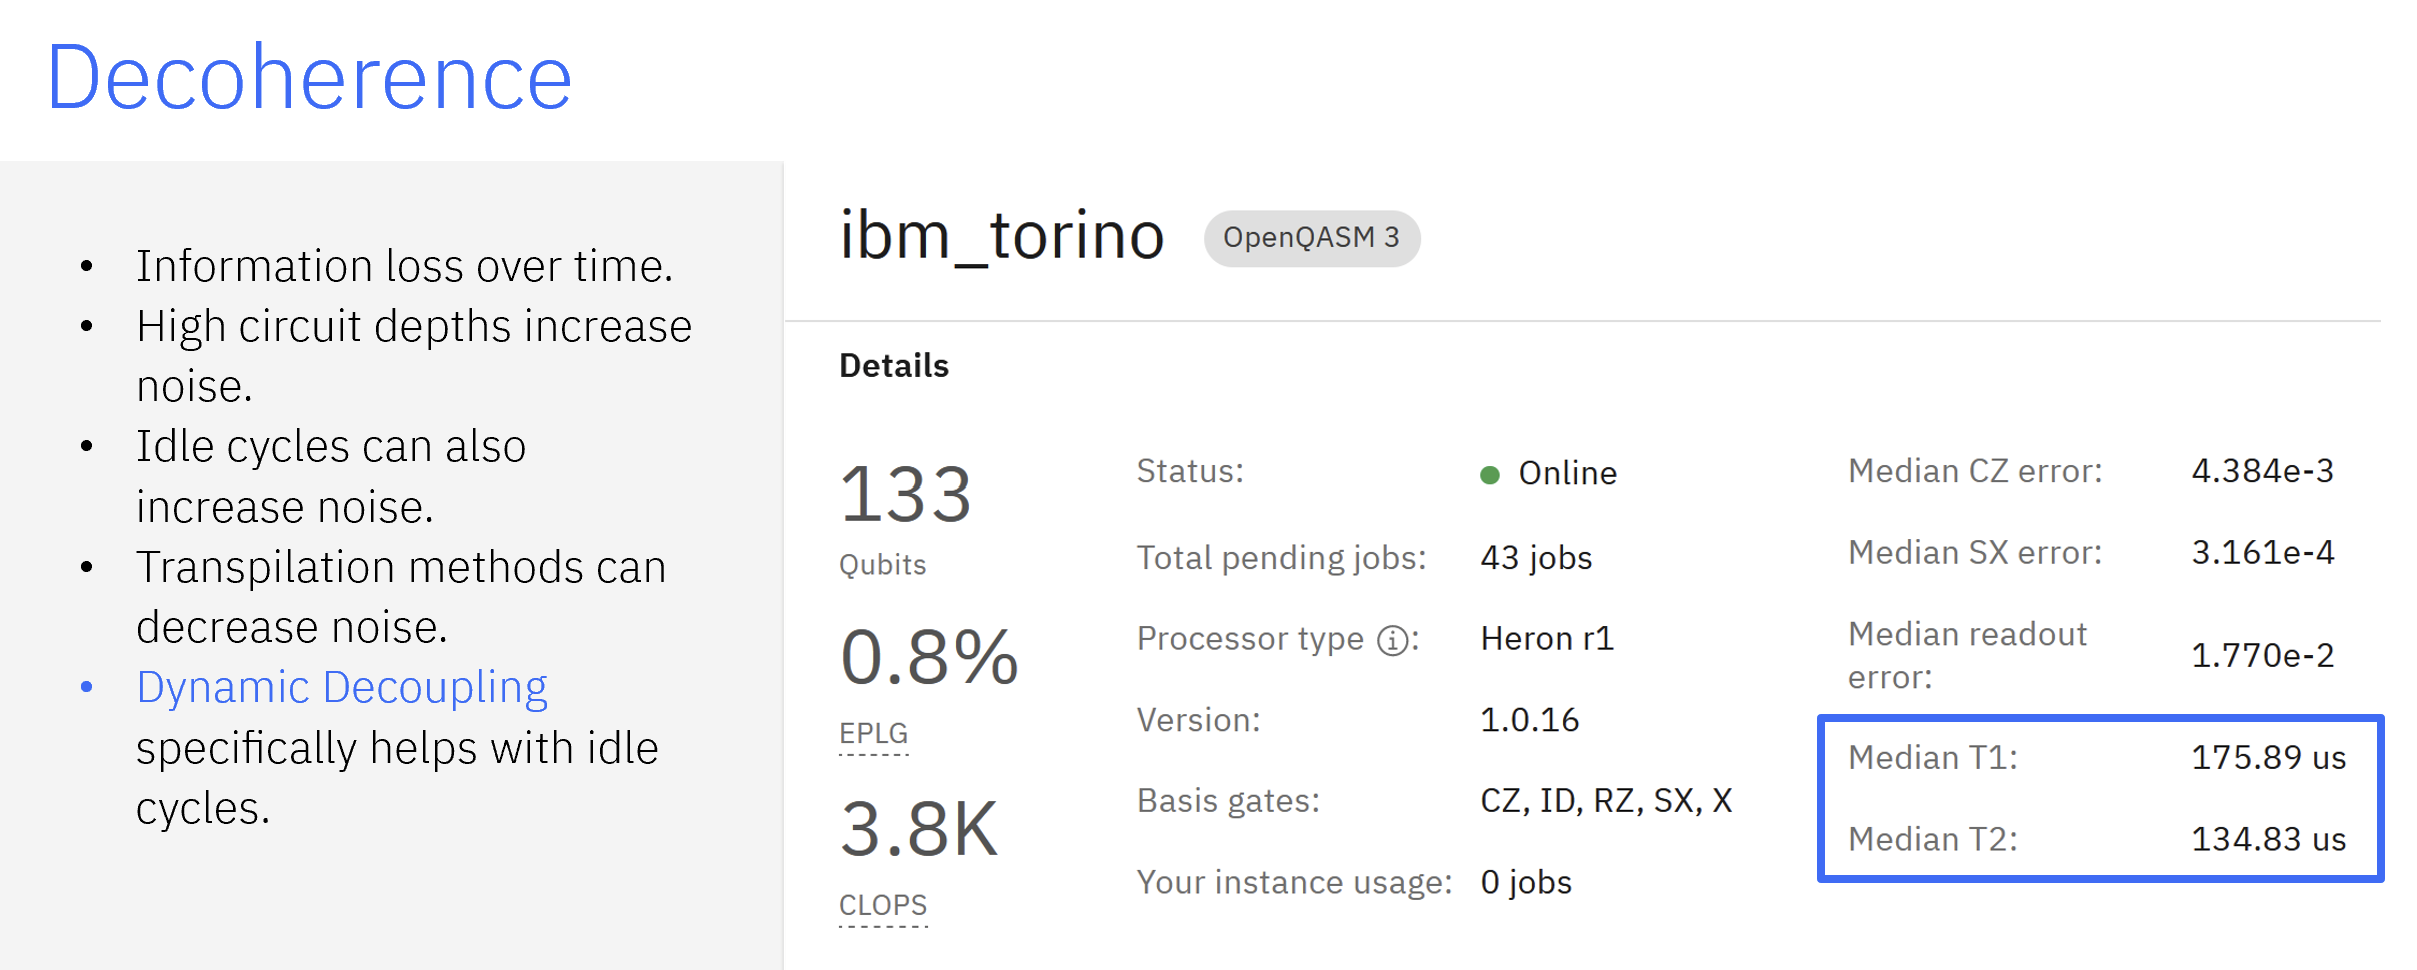

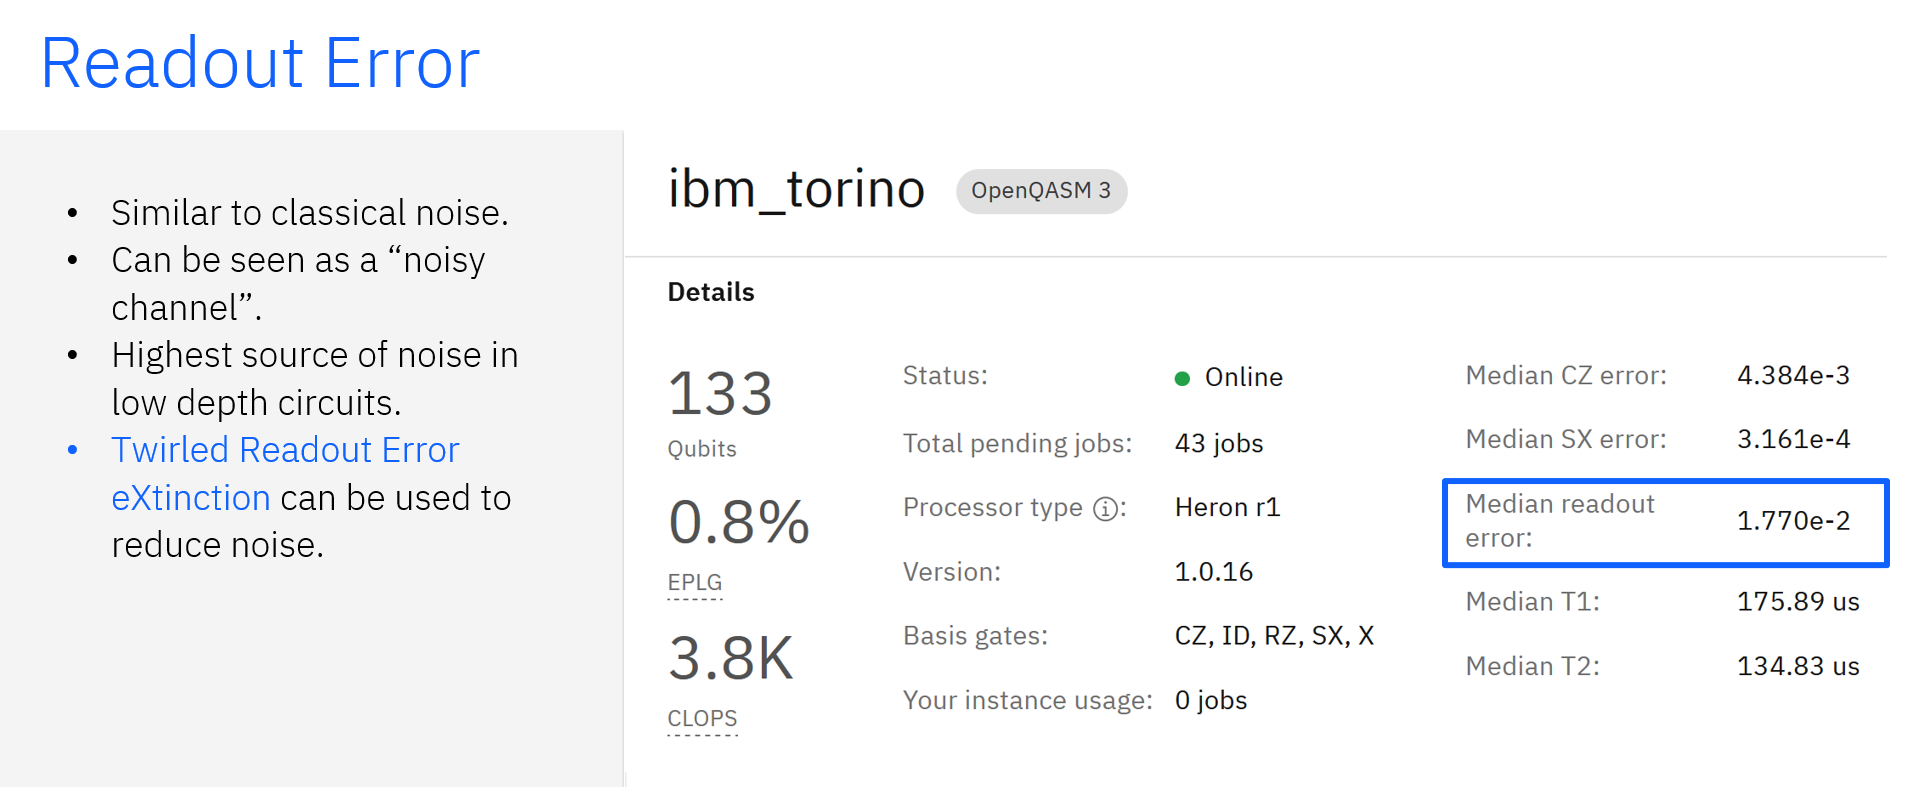

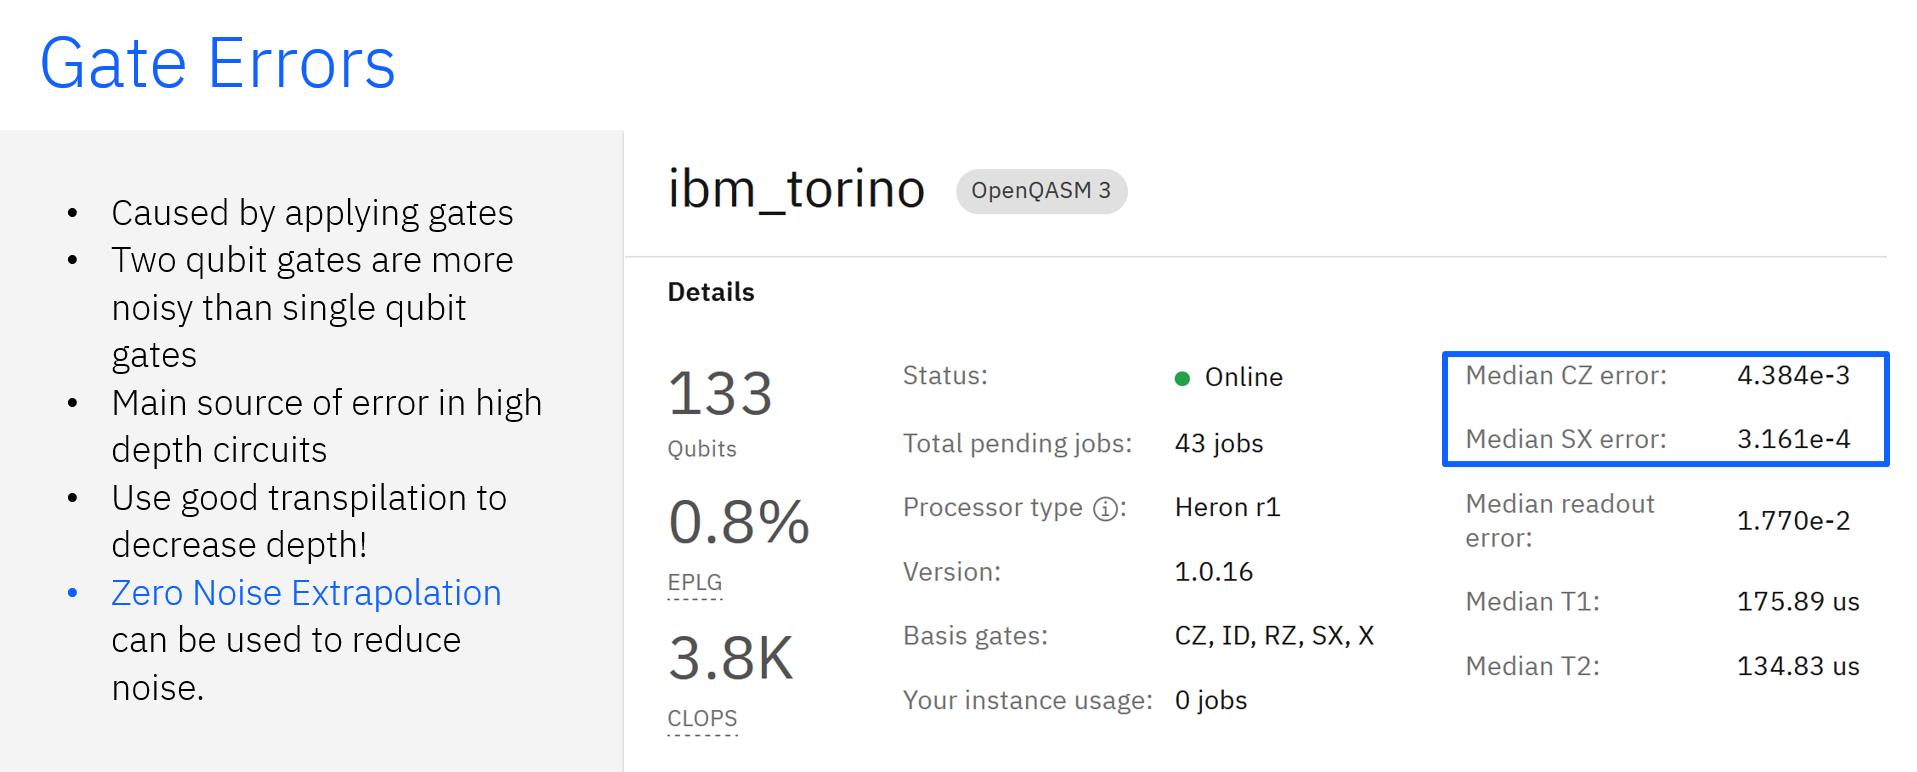

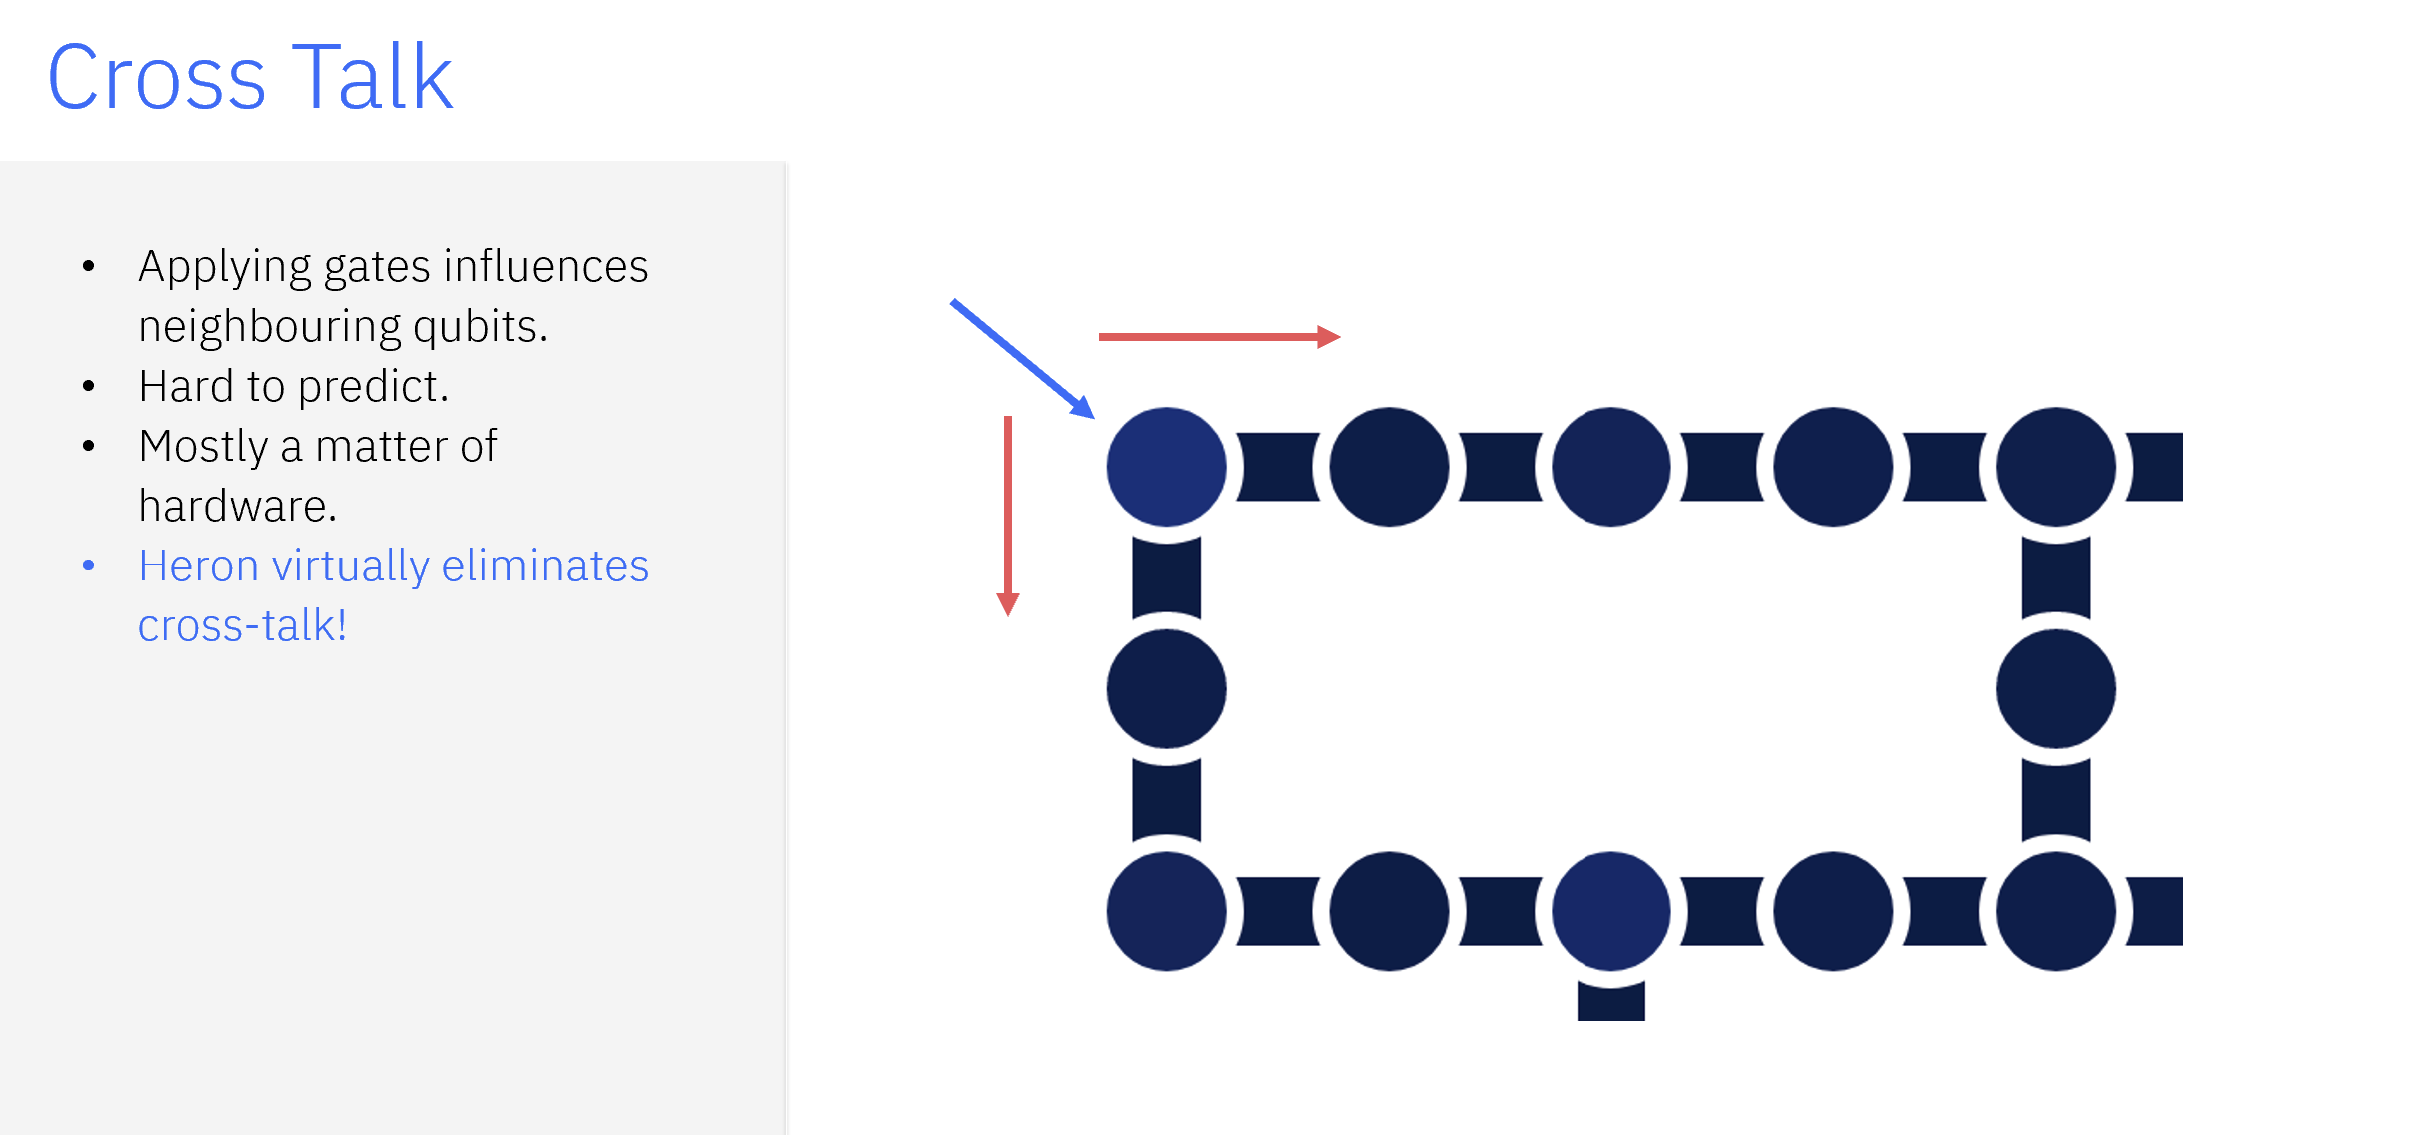

ノイズについてもっと知りたい方は、[Qiskit video](https://www.youtube.com/watch?v=3Ka11boCm1M) で詳しく説明しています。

さて、ノイズについて学んだところで、Qiskit を使ってカスタム fake backend を作成し、ノイズを作ってみたいと思います。このために、 [GenericBackendV2 class](https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.fake_provider.GenericBackendV2) クラスを使用します。このクラスでは、ノイズレベルやシミュレートしたいバックエンドの接続性を指定することができます。ここでは、 `GenericBackendV2` のデフォルトの全対全接続性を仮定します。

In [18]:
fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

汎用バックエンドをそのまま使ってもあまり意味がありません。なぜなら、最終的には、量子回路を動作させたい特定のバックエンドとできるだけ同じような動作をするバックエンドモックを作りたいからです。この Lab では、先ほど作成した汎用的なバックエンドモックのプロパティを変更し、ニーズに合わせる方法を紹介します。

そのために ```update_error_rate``` というヘルパー関数を作ります。

In [19]:
def update_error_rate(backend, error_rates):

    """Updates the error rates of the backend

    Parameters: 
        backend (BackendV2): Backend to update
        error_rates (dict): Dictionary of error rates

    Returns:    
        None
    """

    default_duration=1e-8
    if "default_duration" in error_rates:
        default_duration = error_rates["default_duration"]

    # Update the 1-qubit gate properties 
    for i in range(backend.num_qubits):
        qarg = (i,)
        if "rz_error" in error_rates:
            backend.target.update_instruction_properties('rz', qarg, InstructionProperties(error=error_rates["rz_error"], duration=default_duration))
        if "x_error" in error_rates:
            backend.target.update_instruction_properties('x', qarg, InstructionProperties(error=error_rates["x_error"], duration=default_duration))
        if "sx_error" in error_rates:
            backend.target.update_instruction_properties('sx', qarg, InstructionProperties(error=error_rates["sx_error"], duration=default_duration)) 
        if "measure_error" in error_rates:
            backend.target.update_instruction_properties('measure', qarg, InstructionProperties(error=error_rates["measure_error"], duration=default_duration))            
    
    # Update the 2-qubit gate properties (CX gate) for all edges in the chosen coupling map
    if "cx_error" in error_rates:    
        for edge in backend.coupling_map:
            backend.target.update_instruction_properties('cx', tuple(edge), InstructionProperties(error=error_rates["cx_error"], duration=default_duration))

ここで、この関数を使用してすべてのゲートのエラー率を $1e-8$ に変更し、ゲートの持続時間も同じ数に変更します。

In [20]:
error_rates = {
  "default_duration": 1e-8,
  "rz_error": 1e-8,
  "x_error": 1e-8,
  "sx_error": 1e-8,
  "measure_error": 1e-8,
  "cx_error": 1e-8
}

update_error_rate(fake_backend, error_rates)

### Exercise 4: カスタムFake backendの構築
````{admonition} Exercise
カスタム fake backend を定義し、エラーレートを変えてもう一度 VQC をテストし、Exercise 3 での結果を検証しましょう。

- fake backend や本物のbackendで作業するときは、必ず回路とオブザーバブルの両方をトランスパイルする必要があります。この例は、最近の[Qiskit SDK v1.0 のブログ](https://www.ibm.com/quantum/blog/qiskit-1-0-release-summary#new-primitives-design) の _New primitives design_ セクションにあります。
- `RZ` ゲートと `CX` ゲートのエラーレートを変えて VQC をテストします。いずれの場合も `update_error_rate` 関数を使用する必要があります。
- Exercise 3 での最適なパラメーターを使用してください。
- 以前に作成した関数を使用して、各エラー・レートの合計パフォーマンス(P)を計算し、各鳥のラベルと比較した最終コストをプロットしてください。

```python
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

error_rate_list = [1e-1, 1e-2, 1e-3, 1e-4]

fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

for error_rate_value in error_rate_list:

    update_error_rate # Add your code here
    
    estimator = # Add your code here
    pm = # Add your code here

    opt_params = # Add your code here
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)

    print(f"Performance for run {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions error rate '+str(error_rate_value))
    
ax.legend()
```
````

Performance for run 4: 84.381103515625
Performance for run 4: 86.67449951171875
Performance for run 4: 97.03216552734375
Performance for run 4: 99.530029296875


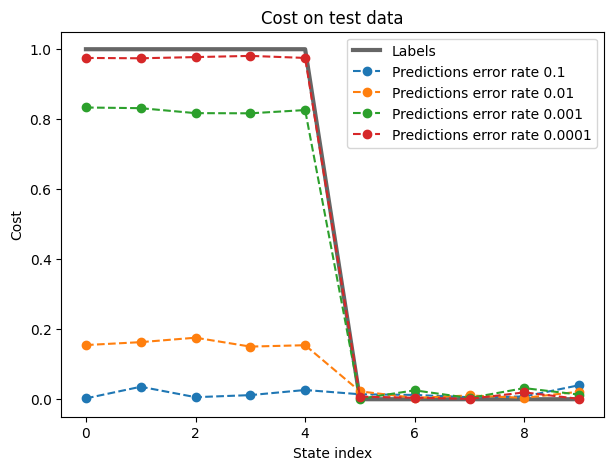

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

error_rate_list = [1e-1, 1e-2, 1e-3, 1e-4]

fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

for error_rate_value in error_rate_list:

    error_rates["rz_error"] = error_rate_value
    error_rates["cx_error"] = error_rate_value
    update_error_rate(fake_backend, error_rates) # Add your code here
    
    estimator = Estimator(fake_backend) # Add your code here
    pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend) # Add your code here

    opt_params = res_list[best_result_index].x # Add your code here
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)

    print(f"Performance for run {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions error rate '+str(error_rate_value))
    
ax.legend()

```{dropdown} 解説
:class: tip
`RZ`と`CX`のエラーレートを`update_error_rate`関数を使って小さくしていくほど予測精度が改善していることがわかります。
```

## Part 3: 量子ハードウェアでVQCをテストする

このパートでは、VQC を実際のハードウェア上で **テスト** します！

そのために、いくつか変更が必要です。現状の主な問題は、これまで考えてきた回路(振幅埋め込み + ansatz)がハードウェアの制限を考慮していないことです。特に、振幅埋め込みとして利用してきた `qc.initialize` は任意の状態ベクトル状態を回路にマッピングできる一般的な関数ではありますが、効率の面では芳しくありません。

データセットの構造に合わせたカスタムマッピングを作成し、回路の深さを削減できるはずです。さらに、これまではすべての量子ビットのペアに対して接続を持つ `RealAmplitudes` ansatz　を検討してきましたが、これは heavy-hex 接続を持つ実際のデバイスにトランスパイルすると多数の SWAP ゲートを必要としてしまいます。

このことを明らかにするために、まず、これまで使ってきた VQC を接続性の限られたデバイスにトランスパイルするとどうなるかをチェックしましょう。  
`AerSimulator` を使用して、実際のバックエンドデータからシミュレータを作成し、デバイスとして使用します。

````{hint}
`AerSimulator.from_backend(backend)` を使用すると、IBM Quantum backend を模倣するようにシミュレータが自動的に設定されます。これは、指定したバックエンドの現在のノイズモデル・基本ゲート・カップリングマップを実装することを意味します。

IBM Quantum backend を模倣したシミュレータを得るもう1つの方法は、 `qiskit_ibm_runtime.fake_provider.FakeBackend()` オブジェクトを使うことです。これも似たような構成のシミュレーターを自動的に作成しますが、ノイズモデルは現状サポートしていません。

Lab のこのパートでは、アクセスできる実際の IBM Quantum backend を選択することをお勧めします。後で本物のバックエンドでコードを実行するためのガイドとして、このシミュレーションを利用するからです。デバイス毎に特性が大きく変わる可能性があるため、テストはデバイスによってはあまりうまくいかない可能性があることを考慮してください。

我々は [ibm_sherbrooke](https://quantum.ibm.com/services/resources?system=ibm_sherbrooke) を使用しました。IBM Quantum platform の [Systems タブ](https://quantum.ibm.com/services/resources?resourceType=current-instance&order=queue%20ASC&view=table) でアクセスできるシステムのリストを見つけるか、以下のコードを実行してください：

```python
    from qiskit_ibm_runtime import QiskitRuntimeService

    service = QiskitRuntimeService()
    # list all available systems
    service.backends()
    # get the least busy system
    backend = service.least_busy()
```
````

In [22]:
# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

まず、 `qc.initialize` を利用してトランスパイルした後の2量子ビット回路の深さを確認してみましょう。

Depth of two-qubit gates:  39


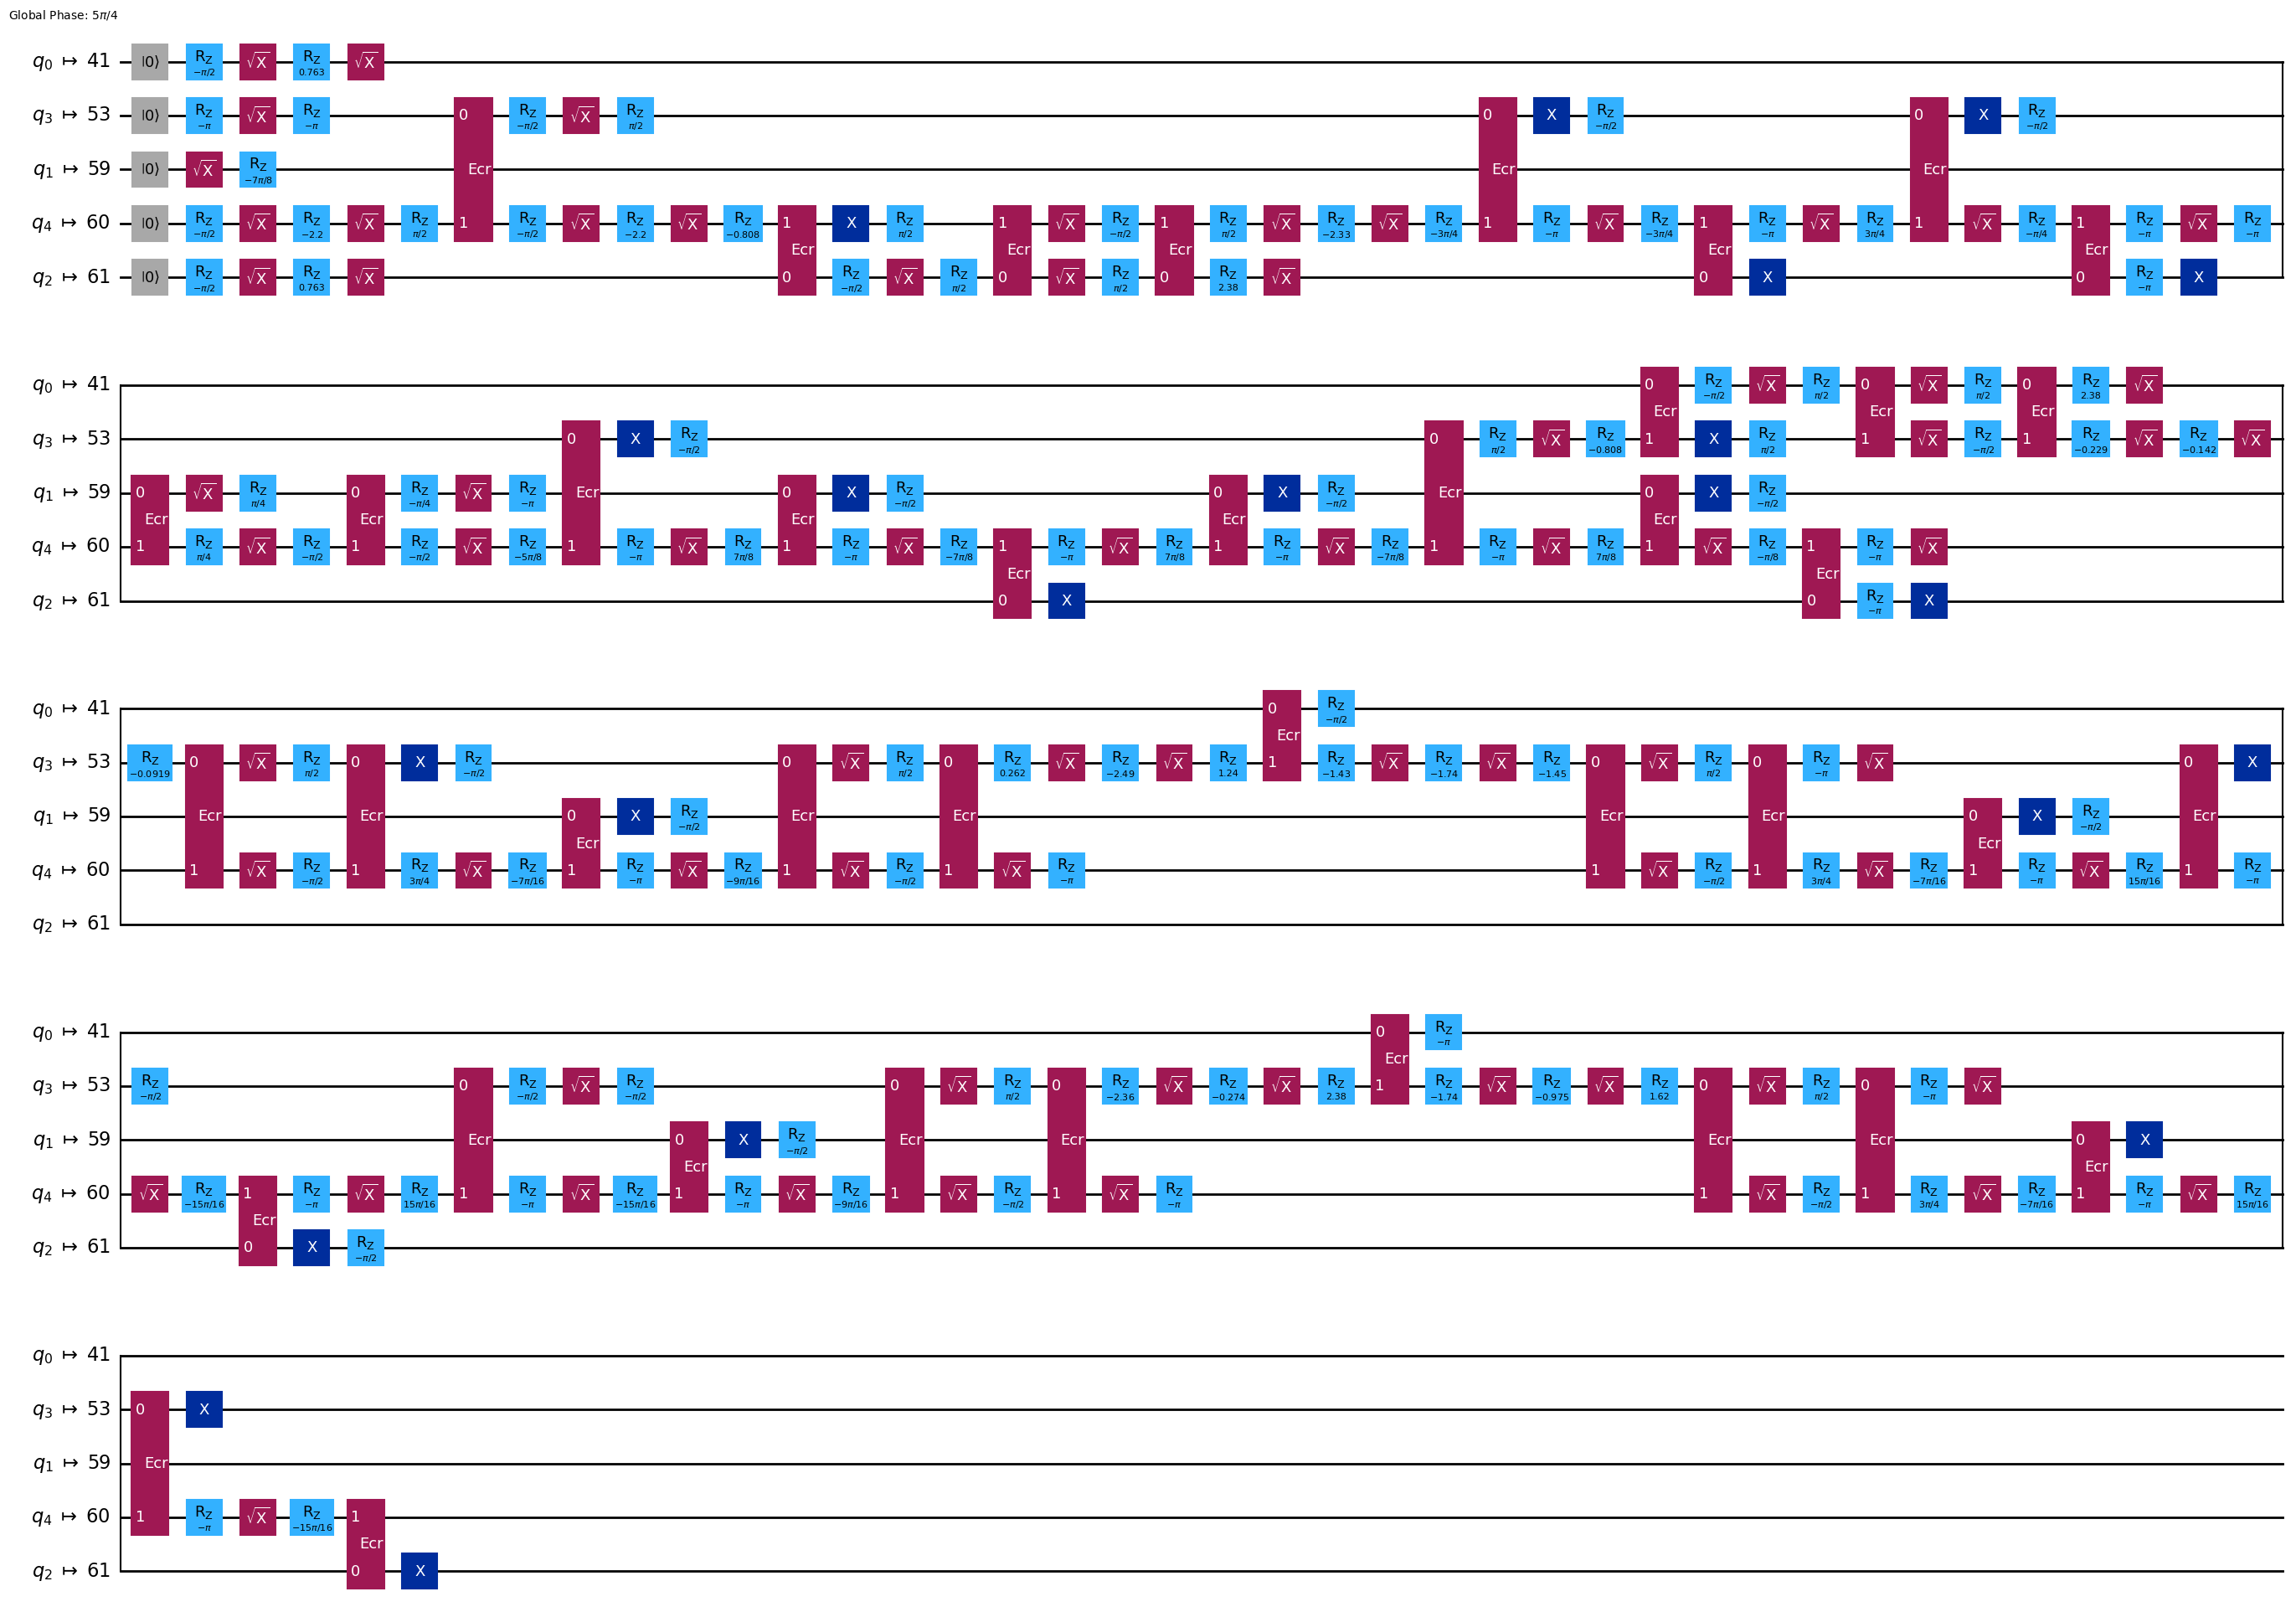

In [23]:
index_bird = 0 #you can check different birds by changing the index
qc = QuantumCircuit(num_qubits)
qc.initialize(list_coefficients[index_bird])
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", idle_wires=False, fold=40)

この回路は実際の量子ハードウェアで動かすには深すぎます！データセットの状態をマッピングする別の方法を探してみましょう。

#### Exercise 5: データセットに合わせたカスタムマッピング
````{admonition}Exercise

状態をより効率的にマッピングする関数を作成します。そのためには、データセットをよく見て、どのように構築されたかを理解する必要があります。ハードウェア上でコードを実行したいときはいつでも、データの構造と問題を賢く利用する必要があります！

- **IBM Quantum の鳥**は、辞書の最初の5つのエントリーに対応し、インデックスは $0$、$1$、$2$、$3$、$4$ です。この状態は次のようにして作成されます：
    - まず、関数  `generate_GHZ` を使ってGHZ 状態を生成することから始めます。
    - 次に、インデックスを5桁の2進数表現に変更します。例えば、鳥番号 $2$ は2進数 $00010$ に対応します。つまり、最後から 2 番目の量子ビットにビット反転を追加する必要があります。
    - これにより最終的なGHZ状態は、鳥番号 $2$ の場合は $\vert 00010 \rangle + \vert 11101 \rangle$ となり、鳥番号 $3$ の場合は $\vert 00011 \rangle + \vert 11100 \rangle$ になります。

- **IBM Quantum でない鳥**は、辞書の後半の5つのエントリーに対応し、インデックスは$5$、$6$、$7$、$8$、$9$ です。ここで、上記の2番目のステップで示したように、状態は鳥のインデックスの2進表現に対応する積状態です。
````

In [24]:
def amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    def generate_GHZ(qc):
        #GHZ state
        qc.h(0)
        for i, j in zip(range(num_qubits-1), range(1,num_qubits)):
            qc.cx(i, j)

            
    ### Write your code below here ###
    qc = QuantumCircuit(num_qubits)
    bird_index_ibmq = (0, 1, 2, 3, 4)
    if bird_index in bird_index_ibmq:
        # generating a GHZ state
        generate_GHZ(qc)
        qc.barrier()
    # change the index to its binary rep with 5 digits
    bird_index_bin = format(bird_index, f'0{num_qubits}b')
    # add a bit flip　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
    for i in range(len(bird_index_bin)):
        if bird_index_bin[i] == '1':
            qc.x(num_qubits-i-1)

        
    ### Don't change any code past this line ###
    return qc

下のセルを使って、正しい状態を作り出せているか確認できます：

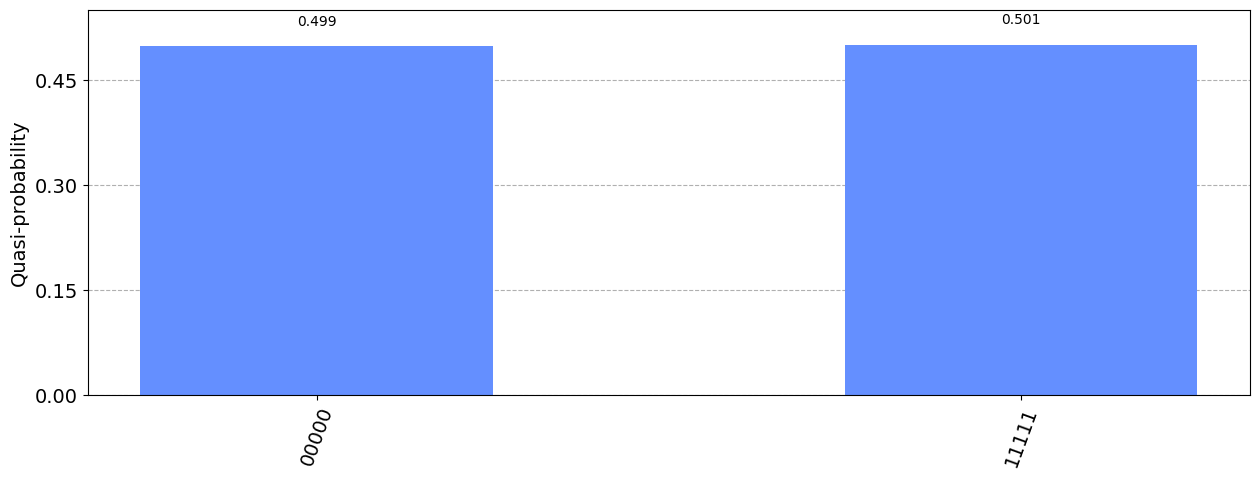

In [25]:
index_bird = 0 # You can check different birds by changing the index

# Build the amplitude embedding 
qc = amplitude_embedding(num_qubits, index_bird)
qc.measure_all()

# Define the backend and the pass manager
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(qc)

# Define the sampler with the number of shots
sampler = Sampler(backend=aer_sim)
result = sampler.run([isa_circuit]).result()
samp_dist = result[0].data.meas.get_counts()
plot_distribution(samp_dist, figsize=(15, 5))

さて、新しい振幅埋め込み回路の深さをチェックしてみましょう：

Depth of two-qubit gates:  4


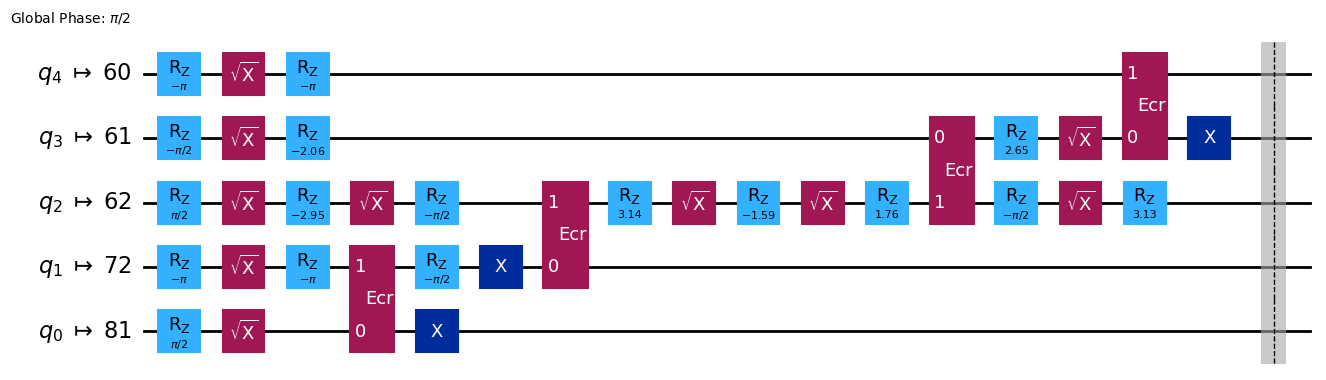

In [26]:
index_bird = 0 #You can check different birds by changing the index
qc = amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

では、完全な接続性を使って、トランスパイルされた `RealAmplitudes` ansatzの深さをチェックしてみましょう。

Depth of two-qubit gates:  16


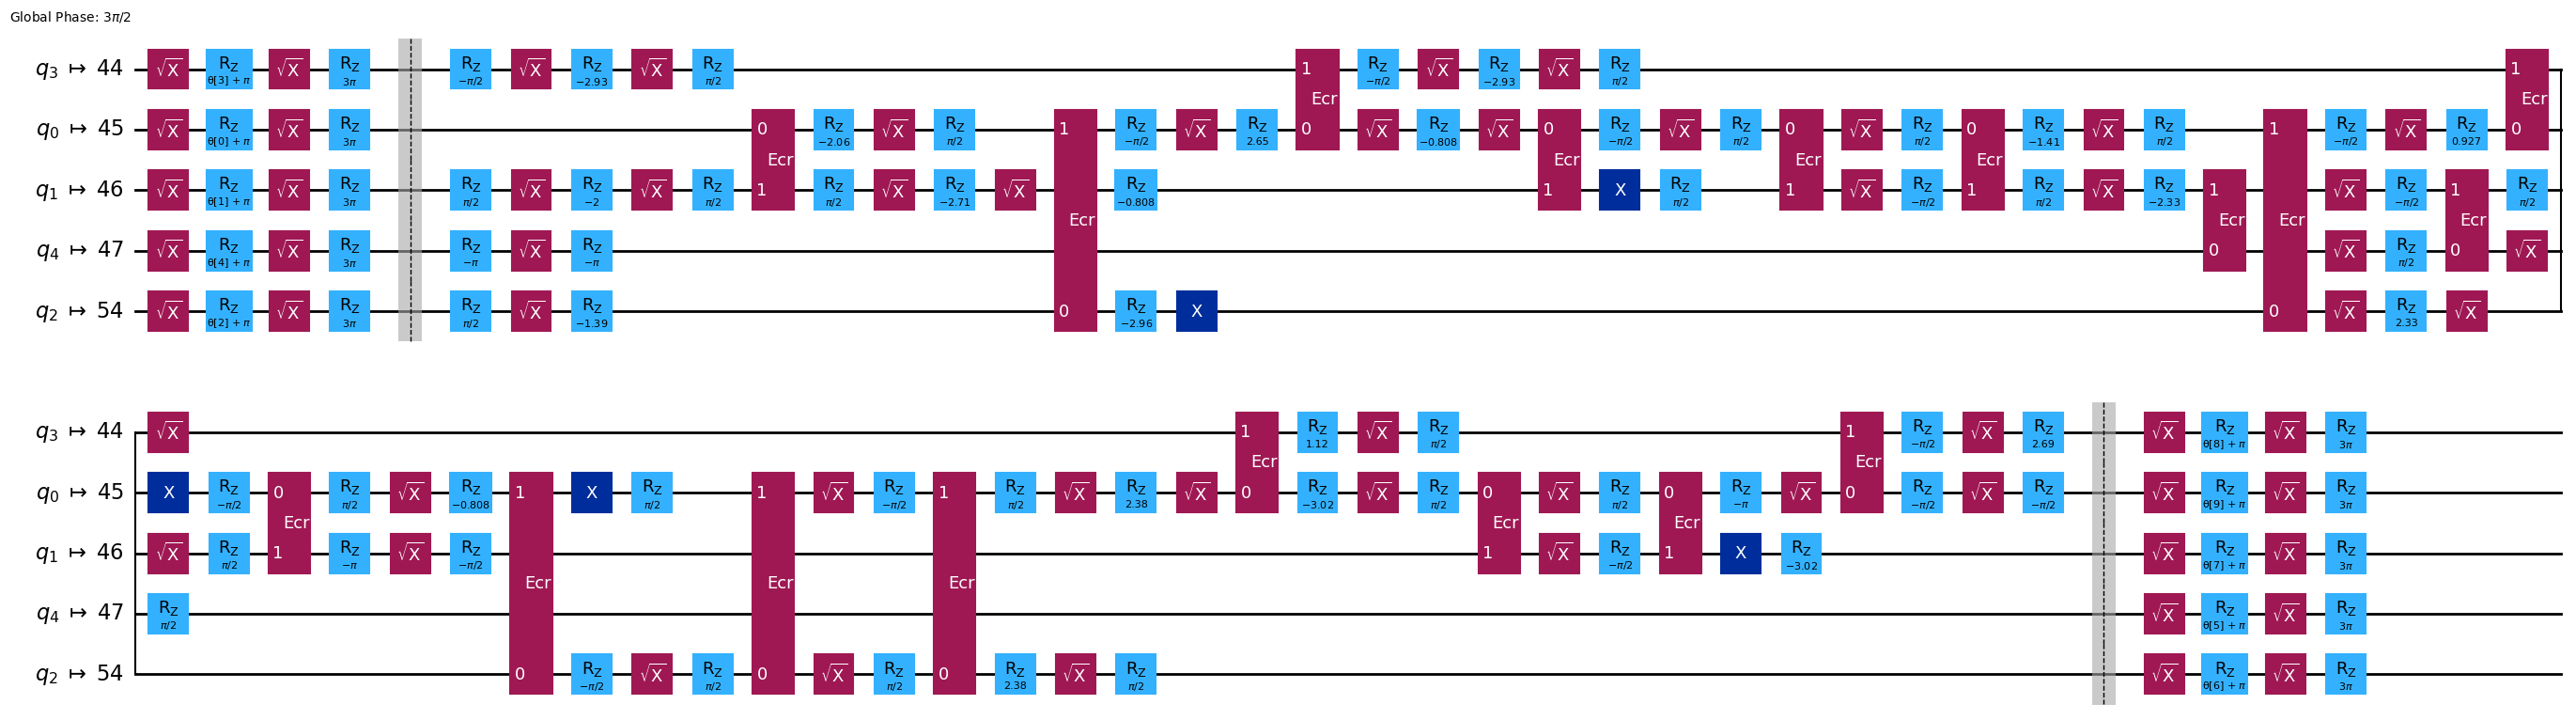

In [27]:
old_ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='full', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(old_ansatz)

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", idle_wires=False, fold=40)

接続性を `pairwise` に変更し、回路の深さを再度確認します。深さはどのくらい減少しましたか?

Depth of two-qubit gates:  2


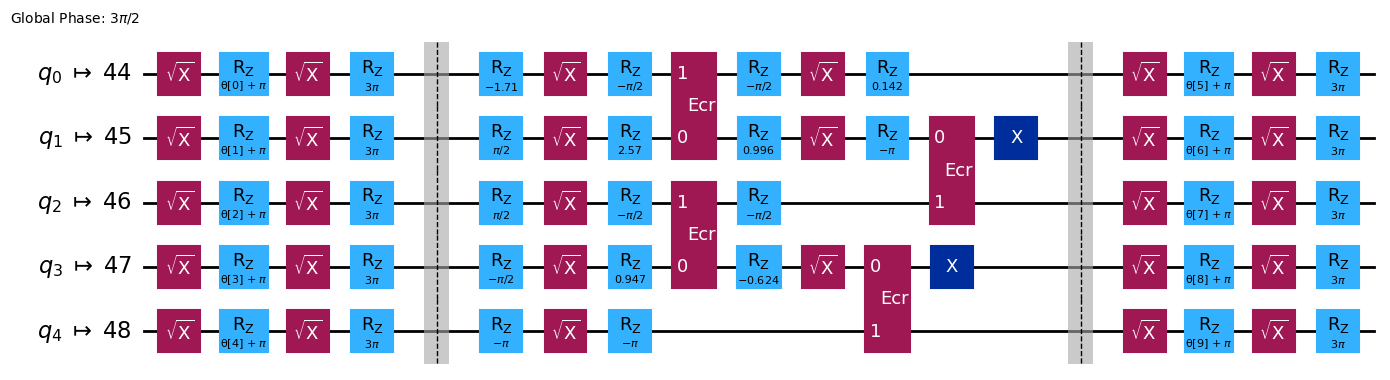

In [28]:
ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='pairwise', insert_barriers=True) # Add your code here
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend) # Add your code here
transpiled_ansatz = pm.run(ansatz) # Add your code here

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", fold=False, idle_wires=False)

ここで、振幅埋め込みと ansatz を組み合わせてトランスパイルすることで、新旧VQC回路の2量子ビットのゲート深さの合計を比較することができます。

In [29]:
old_mapping = QuantumCircuit(num_qubits)
old_mapping.initialize(list_coefficients[index_bird])
old_classifier = old_mapping.compose(old_ansatz)

new_mapping = amplitude_embedding(num_qubits, index_bird)
new_classifier = new_mapping.compose(ansatz)

pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
old_transpiled_classifier = pm.run(old_classifier)
new_transpiled_classifier = pm.run(new_classifier)

print('Old depth of two-qubit gates: ', old_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))
print('Current depth of two-qubit gates: ', new_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))

Old depth of two-qubit gates:  66
Current depth of two-qubit gates:  6


新しいansatzによって、深さは10分の1削減できました！これで、量子ハードウェア上でVQCをテストする準備が整いました。

#### Exercise 6: 結果取得の準備 
````{admonition}Exercise
更新された回路で新しい `test_shallow_VQC` 関数を作成してください。この関数は、新しい振幅埋め込みのステップと新しい ansatz を実装する必要があります。ここでは、各鳥をインデックスで直接マッピングしているので、係数のリストはもう必要ないことに注意してください。
```python
def test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        results_test (list): List of test results
    """
    ### Write your code below here ###



        
    ### Don't change any code past this line ###                       
    return results_test
```
````

In [30]:
def test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier
    Parameters:
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        results_test (list): List of test results
    """
    ### Write your code below here ###
    results_test = []
    for index_bird in range(len(list_labels)):
        amp_embed = amplitude_embedding(ansatz.num_qubits, index_bird)
        new_classifier = amp_embed.compose(ansatz)
        # transpile classifier and observable
        new_transpiled_classifier = pm.run(new_classifier)
        transpiled_obs = obs.apply_layout(layout=new_transpiled_classifier.layout)
        # Run estimator
        pub = (new_transpiled_classifier, transpiled_obs, opt_params)
        job = estimator.run([pub])
        # Get result
        # result = np.abs(job.result()[0].data.evs.item())
        result = np.abs(job.result()[0].data.evs)
        results_test.append(result)


        
    ### Don't change any code past this line ###                       
    return results_test

fake backend で shallow VQC (浅いVQC) をテストしてみましょう！新しいVQCはすでにトレーニング済みなので、 ```opt_params_shallow_VQC.npy``` で与えられた最適なパラメーターを使用できます。

/home/dmurata/workspace/quantum/ibm-quantum-challenge-textbook/.venv/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'default_shots': 5000} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Performance: 97.265625


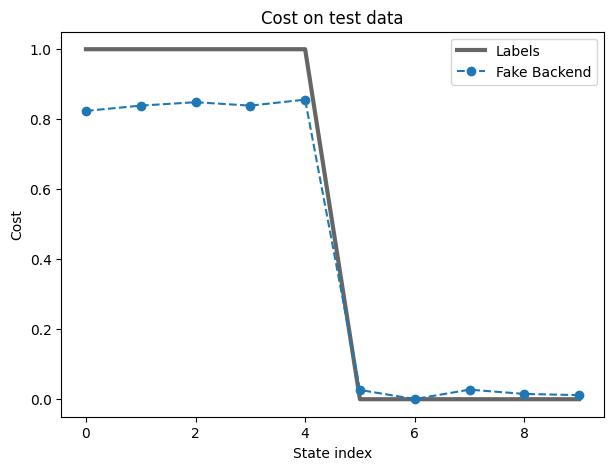

In [31]:
estimator = Estimator(backend=fake_backend)
estimator.options.default_shots = 5000
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

opt_params = np.load('./data/opt_params_shallow_VQC_2024.npy') # Load optimal parameters
results_test = test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm)

print(f"Performance: {compute_performance(results_test, list_labels)}")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')
ax.plot(results_test, 'o--', label='Fake Backend')
ax.legend()

このシミュレーションは、前に選んだ実際のデバイスで得られる結果と似たものになるはずであることに注意してください。ノイズの影響で性能が低下していることがわかりますが、それでも信頼できる結果が得られています。

### 実機でのテスト

この Lab の最後のパートでは、実際の量子ハードウェア上でコードを実行します。

Fake backend を使うことで、ゲートのノイズをシミュレートすることができますが、量子ビットのデコヒーレンスは考慮されていないことに注意してください。この特殊なケースでは、デバイスのほとんどの量子ビットが長期間使用されないため、デコヒーレンスに対処する必要があります。このため、ダイナミック・デカップリング（DD）のようなエラー抑制技術を使用することが非常に重要です。さらに、```resilience_level``` を変化させることで、異なるエラー緩和技術を実装します：

- ```resilience_level = 0```: エラー緩和なし
- ```resilience_level = 1```: **測定トワリング＋トワリング読み出しエラー抑制（TREX）**　を実装。
- ```resilience_level = 2```: **`resilience_level_1` + ゼロノイズ外挿 (ZNE) + ゲート・トワリング** を実装。

これらの各手法について詳しく説明しましょう。

#### Dynamical Decoupling (DD)

上のセクションで述べたように、量子ビットはデコヒーレンスによって時間とともに情報を失い、さらにクロストークによって他の量子ビットに適用される演算の影響を受ける可能性があります。これらの影響は、量子ビットがすでに量子状態で初期化されているにもかかわらず、計算中に長期間使用されなかった場合に特に顕著に現れます。

このような効果を排除するために、 Dynamical Decoupling が利用されます。これは、アイドル状態の量子ビットの状態を反転させるパルスシーケンス（ dynamical decoupling sequences として知られています）を追加することで、デコヒーレンスによるノイズの影響を打ち消し、抑制します。

下の2つの図では、アイドル状態の量子ビットにXゲートが適用されているのがわかります。偶数個のXゲート（パルスシーケンス）を適用していますが、`XX=I`であるため、論理的には量子回路の計算結果に対して影響を与えることなく、物理的な量子ビットに対してノイズの影響を抑制することが出来ます。

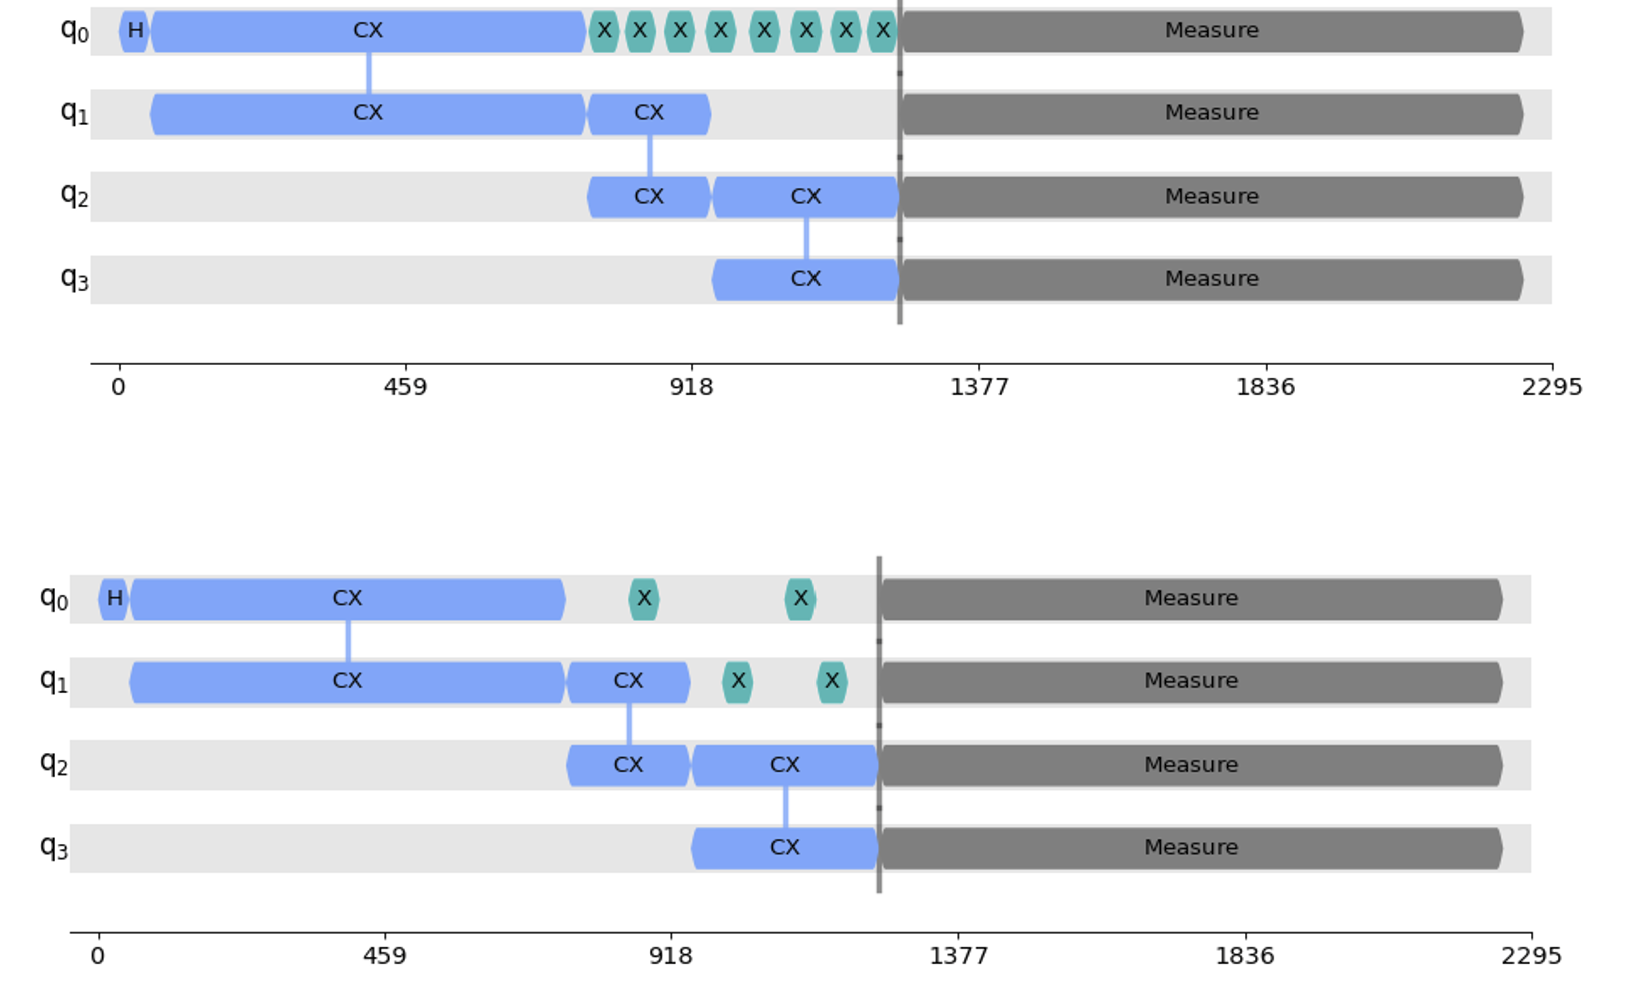

詳細は [こちら](https://docs.quantum.ibm.com/transpile/dynamical-decoupling-pass-manager) をご覧ください。

#### Twirled Readout Error eXtinction (TREX)

TREXは、パウリオブザーバブルの期待値測定時における測定エラーを緩和する手法です。このチャネルは、測定直前にXゲート、直後にを介して量子ビットをランダムに反転させることで、測定時の読み出しエラーを対角化することができます。通常のエラーは異なる状態間で相互に影響し合っていますが、対角化することで異なる状態に対してエラーを独立させることができ補正が容易になります。  
また、測定後に古典ビット反転を挟んで、論理的な計算結果に影響を与えないようにします。

![](https://docs.quantum.ibm.com/_next/image?url=%2Fimages%2Frun%2Ferror-mitigation-explanation%2Fmeasurement_twirling.png&w=2048&q=75)

対角化されたノイズの寄与は、ゼロ状態で初期化されたランダム回路（キャリブレーション回路）によって学習され、補正されます。このキャリブレーション回路の実行が追加で必要となるためにTREXは全体のオーバーヘッドが増加するという特性もあります。

詳細は [こちら](https://arxiv.org/abs/2012.09738) をご覧ください。

#### Zero Noise Extrapolation (ZNE)

ZNEは、Estimator primitive で使用できるエラー緩和手法です。これには2つの異なるフェーズがあります：

- 回路内のノイズ増幅：異なるノイズレベルで期待値を計算
- 外挿：各ノイズレベルでの計算結果を使用して、ノイズがない（ゼロノイズ）場合の期待値を外挿により推定

最初のステップでノイズを増幅する方法いくつかあります。例として、下図のように回路内のゲートを複数回繰り返すゲートフォールディングがあります。

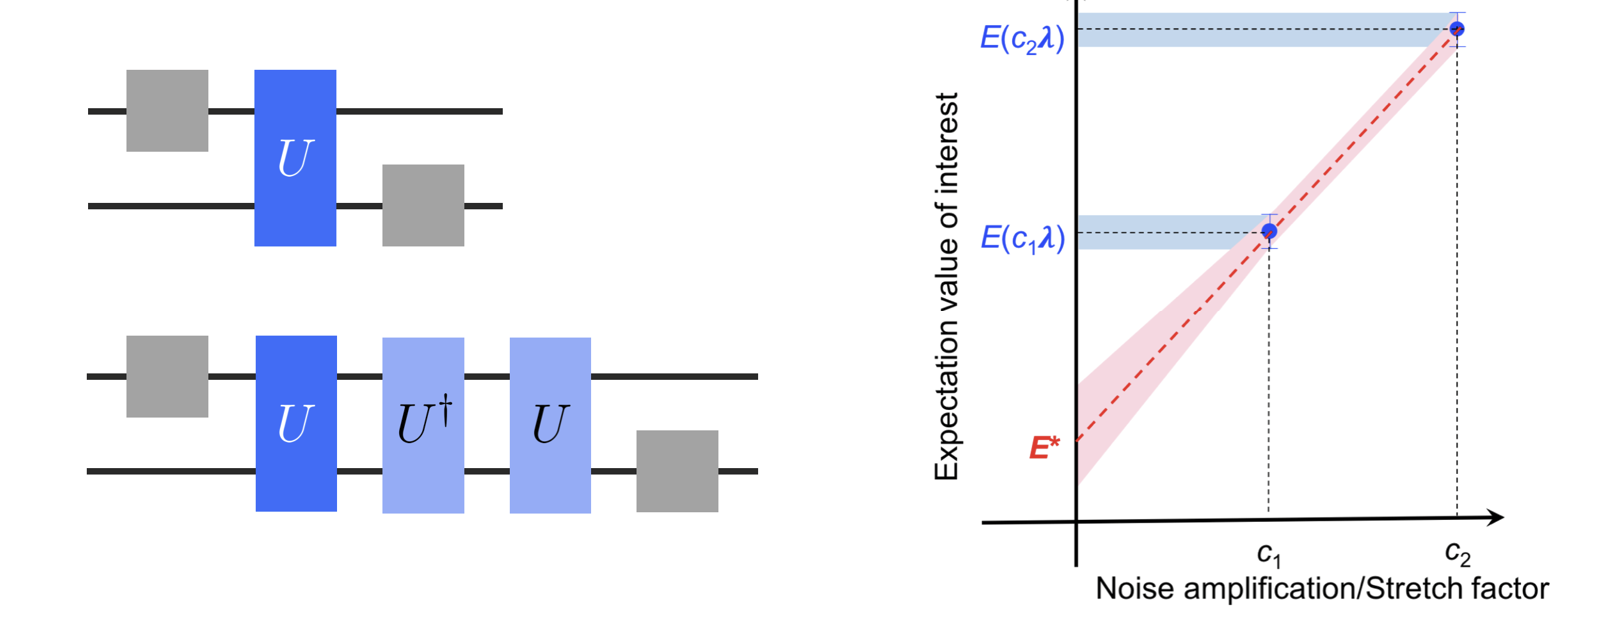

Qiskit runtime でエラー緩和を設定する方法についての詳細は、[このチュートリアル](https://learning.quantum.ibm.com/tutorial/combine-error-mitigation-options-with-the-estimator-primitive)や [ドキュメント](https://docs.quantum.ibm.com/run/configure-error-mitigation) に記載されています。

Estimator primitiveを使用する場合、 ```EstimatorOptions()``` オブジェクトを使用してエラー緩和とエラー抑制技術のオプションを設定することができます。この表は最もよく使われるものを示しています：

| Options              | Sub-options              | Sub-sub-options         | Choices                                                                                   | Default                   |
|----------------------|--------------------------|-------------------------|-------------------------------------------------------------------------------------------|---------------------------|
| default_shots        |                          |                         |                                                                                           | `4096`                      |
| optimization_level   |                          |                         | `0`/`1`                                                                                       | `1`                         |
| resilience_level     |                          |                         | `0`/`1`/`2`                                                                                     | `1`                         |
| dynamical_decoupling | enable                   |                         |`True`/`False`                                                                                           |`False`                           |
|                      | sequence_type            |                         | `'XX'`/`'XpXm'`/`'XY4'`                                                                         | `'XX'`                      |
|                      | extra_slack_distribution |                         | `'middle'`/`'edges'`                                                                          | `'middle'`                  |
|                      | scheduling_method        |                         | `'asap'`/`'alap'`                                                                            | `'alap'`                    |
| resilience           | measure_mitigation       |                         | `True`/`False`                                                                                | `True`                      |
|                      | measure_noise_learning   | num_randomizations      |                                                                                           | `32`                      |
|                      |                          | shots_per_randomization |                                                                                           | `'auto'`                    |
|                      | zne_mitigation           |                         | `True`/`False`                                                                                | `False`                     |
|                      | zne                      | noise_factors           |                                                                                           | `(1, 3, 5)`                 |
|                      |                          | extrapolator            | `'exponential'`/<br>`'linear'`/<br>`'double_exponential'`/<br>`'polynomial_degree_(1 <= k <= 7)'` | (`'exponential'`, `'linear'`) |
| twirling             | enable_gates             |                         | `True`/`False`                                                                                      | `False`                     |
|                      | enable_measure           |                         | `True`/`False`                                                                                      | `True`                      |
|                      | num_randomizations       |                         |                                                                                           | `'auto'`                    |
|                      | shots_per_randomization  |                         |                                                                                           | `'auto'`                    |
|                      | strategy                 |                         | `'active'`/<br>`'active-circuit'`/<br>`'active-accum'`/<br>`'all'`                                | `'active-accum'`            |

まず、VQC をテストする IBM Quantum backend を選択することから始めましょう：

In [32]:
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")

#### Exercise 7: 実機での結果取得の準備
````{admonition}Exercise
IBM Quantum backend で shallow VQC (浅い VQC) をテストする関数を作成してください。この関数は `test_shallow_VQC` に似ていますが、各鳥の pub `pub = (transpiled_classifier, transpiled_obs, opt_params)` を含む pubs のリストを作成する必要があります。そして、pubs のリストを使用して Estimator primitiveを呼び出し、job ID を表示します。

関数の準備ができたら、2つの異なるケースについて `EstimatorOptions()` を定義する必要があります：

- `options_0`: ダイナミック・デカップリングもエラー緩和手法も実装しません。
- `options_1`: シーケンスタイプ `XpXm` と測定トワリング + TREX を用いてダイナミック・デカップリングを実装します。

両ケースとも、ショット数を `5000` 、 `optimization_level=0` に設定してください。

```python
def test_shallow_VQC_QPU(list_labels, ansatz, obs, opt_params, options, backend):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels 
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Estimator options
        backend (service.backend): Backend to run the job 
        
    Returns:
        job_id (str): Job ID
    """

    estimator = Estimator(backend=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

    pubs = []
    for bird, label in enumerate(list_labels):
        ### Write your code below here ###



        
        ### Don't change any code past this line ###
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        pubs.append(pub)

    job = estimator.run(pubs)
    job_id = job.job_id()
    print(f"Job ID: {job_id}")
    print(f"Status: {job.status()}")
                                           
    return job_id
```
````

In [33]:
def test_shallow_VQC_QPU(list_labels, anstaz, obs, opt_params, options, backend):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels 
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Estimator options
        backend (service.backend): Backend to run the job 
        
    Returns:
        job_id (str): Job ID
    """

    estimator = Estimator(backend=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

    pubs = []
    for bird, label in enumerate(list_labels):
        ### Write your code below here ###
        amp_embed = amplitude_embedding(anstaz.num_qubits, bird)
        new_classifier = amp_embed.compose(anstaz)
        transpiled_classifier = pm.run(new_classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
       
        ### Don't change any code past this line ###
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        pubs.append(pub)

    job = estimator.run(pubs)
    job_id = job.job_id()
    print(f"Job ID: {job_id}")
    print(f"Status: {job.status()}")
                                           
    return job_id

In [34]:
## No DD, no TREX (no ZNE)
options_0 = EstimatorOptions() #Add your code here
options_0.optimization_level = 0
options_0.default_shots = 5000
options_0.resilience_level = 0
options_0.dynamical_decoupling.enable = False
options_0.dynamical_decoupling.sequence_type = "XpXm" 
options_0.twirling.enable_measure = False

## DD + TREX (no ZNE)
options_1 = EstimatorOptions() #Add your code here
options_1.optimization_level = 0
options_1.default_shots = 5000
options_1.resilience_level = 1
options_1.dynamical_decoupling.enable = True
options_1.dynamical_decoupling.sequence_type = "XpXm" 

おめでとうございます。これで Lab は終了です。
システムでの実行はオプションで、Grader はありません。以下の事前実行結果を確認するか、自分でセルを実行して結果を確認してください。

```{warning} 
実機でコードを実行する前に、すべてが正しいことを確認してください!

各jobの実行時間は、量子デバイス上では30秒から50秒程度です。そのため、[Open Plan](https://www.ibm.com/quantum/pricing) _(ユーティリティ・スケールのシステムで1ヶ月の実行時間は10分まで)_ でも実行できるはずです。もしキューが長すぎる場合は、job を実行したままにしておいて、後日 `job_id` を下記の `retrieve_job` 関数に渡すことで job を取得することができます。
```

In [35]:
def retrieve_job(job_id):

    ''' Retrieve results from job_id '''

    job = service.job(job_id)

    results_test = []
    errors_test = []
    for result in job.result():
        results_test.append(abs(result.data.evs))
        errors_test.append(abs(result.data.stds))

    return results_test, errors_test

In [36]:
## No DD, no TREX (no ZNE)
job_id_0 = test_shallow_VQC_QPU(list_labels, ansatz, obs, opt_params, options_0, backend)

## DD + TREX (no ZNE)
job_id_1 = test_shallow_VQC_QPU(list_labels, ansatz, obs, opt_params, options_1, backend)

Job ID: csstyjjzsqjg008t92hg
Status: QUEUED
Job ID: csstyktah4b0008cw6v0
Status: QUEUED


DD + TREX + ZNEのジョブを送信することもできます！これにより、さらに良い結果が得られます。ZNEはオーバーヘッドが大きいので、job の実行時間が長くなることに注意してください。

job が終了したら、以下のコードを使って結果をプロットできます：

Performance for no DD + no TREX: 93.506
Performance for DD + TREX: 96.869


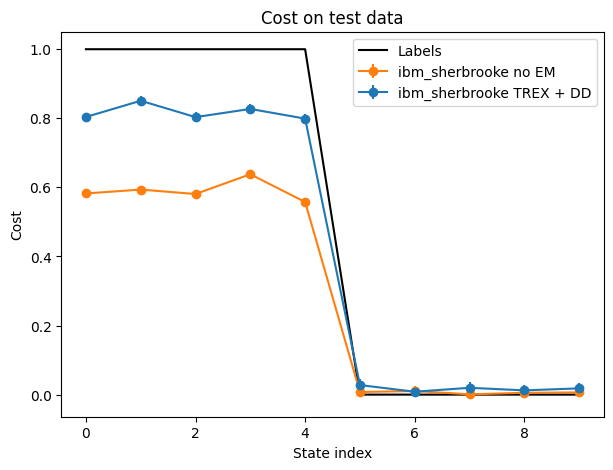

In [37]:
results_test_0_DD, errors_test_0_DD = retrieve_job(job_id_0) #(Add job_id 0 here)
results_test_1_DD, errors_test_1_DD = retrieve_job(job_id_1) #(Add job_id 1 here)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='-o', yerr=errors_test_0_DD, color='tab:orange', label='ibm_sherbrooke no EM')
ax.errorbar(range(10), results_test_1_DD, fmt='-o',  yerr=errors_test_1_DD, color='tab:blue', label='ibm_sherbrooke TREX + DD')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

ノイズレベルが異なるため、使用するデバイスによって結果が異なる可能性があります。これは `ibm_kyiv` で得られた結果の一例です。さまざまなエラー緩和とエラー抑制のテクニックを組み合わせることで、結果が向上していることがわかります。

- **エラー緩和なしでのパフォーマンス：** 86.824
- **DD + TREXを使用した場合のパフォーマンス：** 92.979
- **DD + TREX + ZNEを使用した場合のパフォーマンス：** 98.004


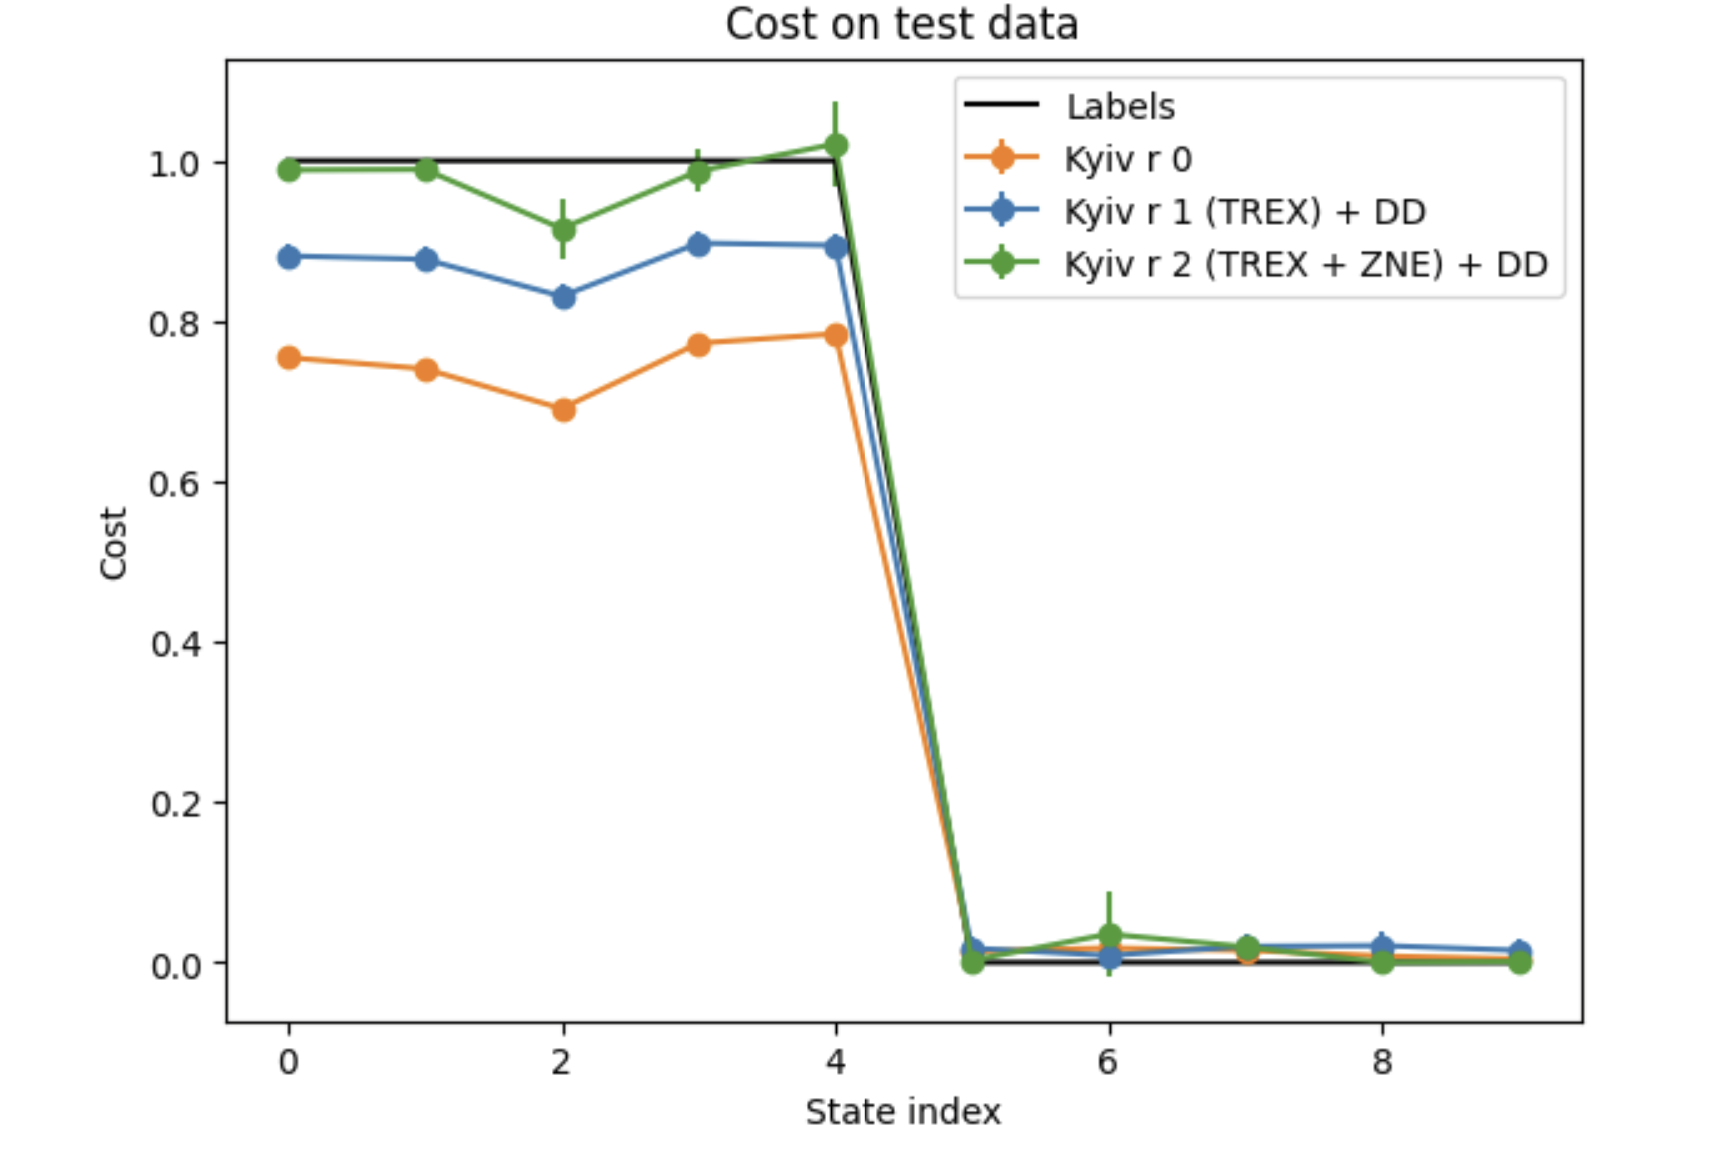

Qiskit Patterns ワークフローを使用した VQC の構築と訓練に関するこの Lab の完了、おめでとうございます！この Exercise を通して、あなたは理想的なバックエンド上で VQC を構築し、訓練する実践経験を得ただけでなく、ノイズが VQC 性能に与える重大な影響についても探求しました。

回路の深さを減らし、実際の量子ハードウェアで VQC を実行することで、現実の量子コンピューティングの課題と解決策を包括的に理解することができました。さらに、実際のバックエンドで VQC をテストすることで、量子エラーレートと計算の忠実度に関する実用的な側面について貴重な洞察を得ることができました。

この Lab と Challenge によって、量子プログラミングのスキルが強化され、量子エラーレートと計算の忠実度の複雑なバランスに対する理解が深まったことを願っています。これからも実験と学習を続け、量子技術の可能性の限界に挑戦してください。量子コンピューティングをマスターする旅は、チャレンジングであると同時にエキサイティングでもある。

さらなる学習とリソースについては、[IBM Quantum Learning platform](https://learning.quantum.ibm.com/) をご覧ください。

**Happy coding with Qiskit!**


## 追加情報

**Created by:** Joana Fraxanet, Marcel Pfaffhauser, Junye Huang

**Advised by:** Vishal Sharathchandra Bajpe, Pedro Rivero, Blake Johnson,  Paul Nation

**Translated by:** Kifumi Numata

**Version:** 1.2.0